<a href="https://colab.research.google.com/github/ItsShi/Graph-Neural-Network-for-Similarity-Learning/blob/main/task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


# Task 3

[-7, -10, -2, -1, -2, 0] [-4, 3, 4, 1, -2, 0] [-8, -4, -3, -2, 0, 1]
[[ 0.97746715  0.12001787 -0.17364818 -1.        ]
 [-0.11578004  0.99268008  0.03436929 -2.        ]
 [ 0.17650202 -0.01348986  0.98420783  0.        ]
 [ 0.          0.          0.          1.        ]]
[[ 0.97492183  0.18800639 -0.11908413 -0.13551867]
 [-0.19200018  0.98112771 -0.0228988  -3.92483273]
 [ 0.11253162  0.04518871  0.99262008 -0.07494209]
 [ 0.          0.          0.          1.        ]]
[[ 0.92857623  0.31878497 -0.19005876 -2.67354576]
 [-0.31606589  0.94765577  0.04528674 -3.86887203]
 [ 0.19454701  0.0180189   0.98072768  1.08036726]
 [ 0.          0.          0.          1.        ]]
[-7, -10, -2, -1, -2, 0] [-4, 3, 4, 1, -2, 0] [-8, -4, -3, -2, 0, 1]
[[ 0.97746715  0.12001787 -0.17364818 -1.        ]
 [-0.11578004  0.99268008  0.03436929 -2.        ]
 [ 0.17650202 -0.01348986  0.98420783  0.        ]
 [ 0.          0.          0.          1.        ]]
[[ 0.97492183  0.18800639 -0.11908413 -0.1

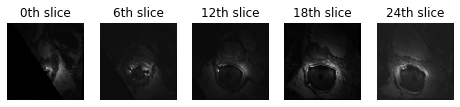

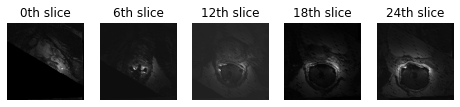

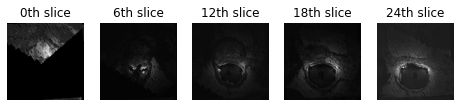

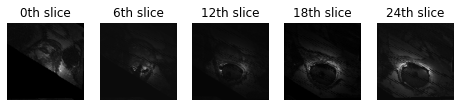

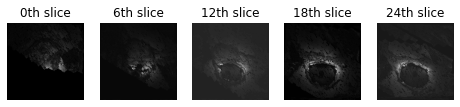

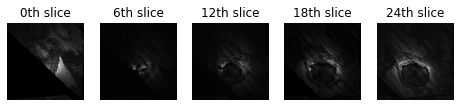

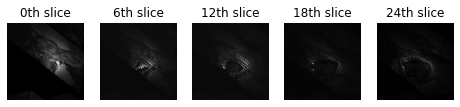

In [ ]:
import random 
import numpy as np
import matplotlib.pyplot as plt


class RigidTransform():
    def __init__(self, rigid_para, warp_size):
        """
        Given 6 rigid transformation parameters, 3 rotaions and 3 translations as input
        Precompute  a translation vectorand a rotation matrix
        Args:
            rigid_para (List: 6 items): the 6 rigid transformation parameters to convert. 3 for rotation and 3 for transformation.
        Attributes:
            rot_matrix (narray: (3,3)): the rotation matrix[[c5c6,         c5s6,           s5],
                                                            [-s4s5c6-c4s6, -s4s5s6+c4c6,  s4c5],
                                                            [-c4s5c6+s4s6, -c4s5s6-s4c6, c4c5]]
                    where s4, s5 and s6 are the sines, and c4, c5 and c6 are the cosines of parameters q4, q5 and q6 respectively.
            tran_vector ((3,)): the translation vector [q1, q2, q3]
        Image coordinate system:           
            in the unit of voxel
                origin o
                  o +----> axis0    slice
                   /|
            axis1 / |           axial    orientation
                 L  |
                    v
                  axis2
        """            
        a1, a2, a3, t1, t2, t3 = rigid_para
        a1, a2, a3 = np.deg2rad(a1), np.deg2rad(a2), np.deg2rad(a3)
        rigid_T, R_z, R_y, R_x = np.eye(4,4), np.eye(3,3), np.eye(3,3), np.eye(3,3)
        sinz, cosz, siny, cosy, sinx, cosx = np.sin(a1), np.cos(a1), np.sin(a2), np.cos(a2), np.sin(a3), np.cos(a3)
        # Rotation matrix 3x3 about z-axis is given by 
        #       [[cosA, -sinA, 0],
        #       [sinA, cosA,  0],
        #       [0,     0,    1]] where A = angle of rotation
        R_z[0,0], R_z[0,1], R_z[1,0], R_z[1,1] = cosz, -sinz, sinz, cosz

        # Rotation matrix 3x3 about y-axis is given by 
        #       [[cosA,   0,  sinA],
        #       [ 0,     1,   0  ],
        #       [-sinA,  0,  cosA]] where A = angle of rotation
        R_y[0,0], R_y[0,2], R_y[2,0], R_y[2,2] = cosy, siny, -siny, cosy

        # Rotation matrix 3x3 about x-axis is given by 
        #       [[1,     0,      0],
        #       [0,  cosA,  -sinA],
        #       [0,  sinA,   cosA]] where A = angle of rotation
        R_x[1,1], R_x[1,2], R_x[2,1], R_x[2,2] = cosx, -sinx, sinx, cosx

        # final Rotation matrix 
        R = np.matmul(R_y, R_z)
        R = np.matmul(R_x, R)
        # Calculating extrinsic marix using rotation and translation
        # Rigid transformation matrix 4x4 taking into account
        #   rotation and translation is given by
        #   [[R, t],
        #    [0, 1]]        where R = Net Rotation matrix, t = Translation vector
        # Calculating extrinsic marix using rotation and translation
        
        t = np.array([t1,t2,t3])
        rigid_T[:3,:3], rigid_T[:3,3] = R, t
        self.rigid_T = rigid_T

        # calculate an inverse rigid transformation matrix to fill in the target image
        # R_inv = R.T
        # t_inv = np.matmul(-R_inv,t)
        # rigid_inv = np.eye(4,4)
        # rigid_inv[:3,:3], rigid_inv[:3,3] = R_inv, t_inv 
        # self.rigid_T = rigid_inv
        # self.t = t_inv
        # self.R = R_inv
        self.warp_size = warp_size
        self.ddf = self._compute_ddf(warp_size)

    def _compute_ddf(self, warp_size):
        """
        Given a warped image size, return a dense displacement field for each warped image voxel
        Args:
            warp_size (3-item tuple): warped image size
        Return:
            ddf (narray: (*(warp_size, 3))): 3D displacement vector (x,y,z) from warped image to original image at each warped image voxel location 
        """    

        centre = (np.array(warp_size)-1)/2 # rotate around the centre of warped image     
        ddf = np.ones((*warp_size,3))
        for z in range(warp_size[0]):
            for x in range(warp_size[1]):
                for y in range(warp_size[2]):
                    # homogenious coordinate for convinience using transformation matrix
                    # each point rotate around warped image centre, homogenious coords convinient for computation
                    ijk_homo = np.array([[z-centre[0], x-centre[1], y-centre[2], 1]]).T 
                    # displace back to the coordinate that the origin is the upper left corner
                    mapped_z, mapped_x, mapped_y = np.matmul(self.rigid_T, ijk_homo).T[0][:3] + centre
                    ddf[z,x,y,:] = mapped_z-z, mapped_x-x, mapped_y-y    
        return ddf
    
    def warp(self, image):
        """
        Given a image volume, return a warped image volume
        Args:
            image (narray: (32,128,128)): image volume
        Return:
            warp_img (narray): warped image volume in numpy array
        """                 
        warp_img = np.ones(image.shape)
        for z in range(warp_img.shape[0]):
            for x in range(warp_img.shape[1]):
                for y in range(warp_img.shape[2]): 
                    mapped_z, mapped_x, mapped_y =  self.ddf[z,x,y,0]+z, self.ddf[z,x,y,1]+x, self.ddf[z,x,y,2]+y
                    # The larger you make your target image, the less it will resemble the document in the source image
                    # there are some points in target image plane for which there is no mapping to source points on source image plane. 
                    # so here is to calculate an inverse rigid transformation matrix to fill in the target image
                    try: #warp_img[z, x, y] = image[int(mapped_z), int(mapped_x), int(mapped_y)]
                        warp_img[int(mapped_z), int(mapped_x), int(mapped_y)] = image[z, x, y]# this causes massive noise and strains
                        # warp_img[z, x, y] = image[int(mapped_z), int(mapped_x), int(mapped_y)]            
                    except: pass 
        return warp_img
    
    def _compose_ddf(self, ddf1, ddf2):
        """
        take two DDFs as input and returns the composed DDF
        Args:
            ddf1 narray: (*(warp_size, 3))): 3D displacement vector (x,y,z) from warped image to original image at each warped image voxel location 
            ddf2 narray: (*(warp_size, 3))): 3D displacement vector (x,y,z) from warped image to original image at each warped image voxel location 
        Return:
            compose of ddf1 and ddf2, which is the vector sum of 2 displcement field
        """
        composed_ddf = ddf1 + ddf2
        return composed_ddf

    def compose(self, rigid_para, flag_composing_ddf=False):
        """
        Update the previously-defined rotation matrix, translations vector and DDF
        Args:
            rigid_para (List: 6 items): another 6 rigid transformation parameters
            flag_composing_ddf (boolean): if set true, 
                function uses a different algorithm to compute the composed DDF 'composing_ddfs'
        return:
            RigidTransform object: represents a composed rigid transformation
        """
        # update rot, tran, ddf
        a1, a2, a3, t1, t2, t3 = rigid_para
        a1, a2, a3 = np.deg2rad(a1), np.deg2rad(a2), np.deg2rad(a3)
        rigid_T, R_z, R_y, R_x = np.eye(4,4), np.eye(3,3), np.eye(3,3), np.eye(3,3)
        sinz, cosz, siny, cosy, sinx, cosx = np.sin(a1), np.cos(a1), np.sin(a2), np.cos(a2), np.sin(a3), np.cos(a3)
        R_z[0,0], R_z[0,1], R_z[1,0], R_z[1,1] = cosz, -sinz, sinz, cosz
        R_y[0,0], R_y[0,2], R_y[2,0], R_y[2,2] = cosy, siny, -siny, cosy
        R_x[1,1], R_x[1,2], R_x[2,1], R_x[2,2] = cosx, -sinx, sinx, cosx
        R = np.matmul(R_y, R_z)
        R = np.matmul(R_x, R)
        t = np.array([t1,t2,t3])
        rigid_T[:3,:3], rigid_T[:3,3] = R, t
        # self.rigid_T = np.matmul(self.rigid_T, rigid_T)
        self.rigid_T = np.matmul(rigid_T, self.rigid_T)

        # R_inv = R.T
        # t_inv = np.matmul(-R_inv,t)
        # rigid_inv = np.eye(4,4)
        # rigid_inv[:3,:3], rigid_inv[:3,3] = R_inv, t_inv 
        # update composed transformation
        # self.rigid_T = np.matmul(rigid_inv,self.rigid_T)
        # self.rigid_T = np.matmul(self.rigid_T, rigid_inv)
        # update ddf
        if flag_composing_ddf:
            self.ddf = self._compose_ddf(self.ddf, self._compute_ddf(self.warp_size))
        else: self.ddf = self._compute_ddf(self.warp_size)


image_array = np.load('/content/drive/MyDrive/ucl/image_train00.npy') #(32, 128, 128)

##############
# experiment 1
##############

# manually define a range for rotation and translation parameters
random.seed(42)
# [-11, -17, -1, -1, -2, 0] [-4, 3, 4, 1, -2, 0] [-8, -4, -3, -2, 0, 1]
T1 = [*random.sample(range(-10, 10), 3),*random.sample(range(-2, 2), 3)]
T2 = [*random.sample(range(-5, 5), 3),*random.sample(range(-2, 2), 3)]
T3 = [*random.sample(range(-10, 10), 3),*random.sample(range(-2, 2), 3)]
print(T1, T2, T3)
# sample 3 sets of rigid transformation parameters T1, T2 and T3
# instantiate 3 objects such that they represent three rigid transformations T1, T1composeT2, T1compseT2composeT3
T1 = RigidTransform(T1, (32,128,128))
print(T1.rigid_T)
warped1 = T1.warp(image_array)

#compose
T1.compose(T2)
print(T1.rigid_T)
warped2 = T1.warp(image_array)

T1.compose(T3)
print(T1.rigid_T)
warped3 = T1.warp(image_array)

# sequential
T2 = RigidTransform(T2, (32,128,128))
T3 = RigidTransform(T3, (32,128,128))
warp2 = T2.warp(warped1)
warp3 = T3.warp(warp2)

##############
# experiment 2
##############
random.seed(42)
# [-11, -17, -1, -1, -2, 0] [-4, 3, 4, 1, -2, 0] [-8, -4, -3, -2, 0, 1]
T1 = [*random.sample(range(-10, 10), 3),*random.sample(range(-2, 2), 3)]
T2 = [*random.sample(range(-5, 5), 3),*random.sample(range(-2, 2), 3)]
T3 = [*random.sample(range(-10, 10), 3),*random.sample(range(-2, 2), 3)]
print(T1, T2, T3)
# sample 3 sets of rigid transformation parameters T1, T2 and T3
# instantiate 3 objects such that they represent three rigid transformations T1, T1composeT2, T1compseT2composeT3
T1 = RigidTransform(T1, (32,128,128))
print(T1.rigid_T)
exp2_warped1 = T1.warp(image_array)

#compose
T1.compose(T2, flag_composing_ddf=True)
print(T1.rigid_T)
exp2_warped2 = T1.warp(image_array)

T1.compose(T3, flag_composing_ddf=True)
print(T1.rigid_T)
exp2_warped3 = T1.warp(image_array)

# sequential
T2 = RigidTransform(T2, (32,128,128))
T3 = RigidTransform(T3, (32,128,128))
warp2 = T2.warp(warped1)
warp3 = T3.warp(warp2)



########
# plot
########
fig, ax = plt.subplots(1, 5, figsize=(8,8))
for i in range(5):
    ax.flatten()[i].imshow(warped1[i*6], cmap='gray'), ax.flatten()[i].set_title(str(i*6)+"th slice"), ax.flatten()[i].axis('off')
fig.savefig('T1', transparent=True)
plt.show()

fig, ax = plt.subplots(1, 5, figsize=(8,8))
for i in range(5):
    ax.flatten()[i].imshow(warped2[i*6], cmap='gray'), ax.flatten()[i].set_title(str(i*6)+"th slice"), ax.flatten()[i].axis('off')
fig.savefig('T1 compose T2', transparent=True)
plt.show()

fig, ax = plt.subplots(1, 5, figsize=(8,8))
for i in range(5):
    ax.flatten()[i].imshow(warp2[i*6], cmap='gray'), ax.flatten()[i].set_title(str(i*6)+"th slice"), ax.flatten()[i].axis('off')
fig.savefig('T1 then T2', transparent=True)
plt.show()

fig, ax = plt.subplots(1, 5, figsize=(8,8))
for i in range(5):
    ax.flatten()[i].imshow(warped3[i*6], cmap='gray'), ax.flatten()[i].set_title(str(i*6)+"th slice"), ax.flatten()[i].axis('off')
fig.savefig('T1 compose T2 compose T3', transparent=True)
plt.show()

fig, ax = plt.subplots(1, 5, figsize=(8,8))
for i in range(5):
    ax.flatten()[i].imshow(warp3[i*6], cmap='gray'), ax.flatten()[i].set_title(str(i*6)+"th slice"), ax.flatten()[i].axis('off')
fig.savefig('T1 then T2 then T3', transparent=True)
plt.show()


##########################

fig, ax = plt.subplots(1, 5, figsize=(8,8))
for i in range(5):
    ax.flatten()[i].imshow(exp2_warped2[i*6], cmap='gray'), ax.flatten()[i].set_title(str(i*6)+"th slice"), ax.flatten()[i].axis('off')
fig.savefig('T1_compose_T2', transparent=True)
plt.show()


fig, ax = plt.subplots(1, 5, figsize=(8,8))
for i in range(5):
    ax.flatten()[i].imshow(exp2_warped3[i*6], cmap='gray'), ax.flatten()[i].set_title(str(i*6)+"th slice"), ax.flatten()[i].axis('off')
fig.savefig('T1_compose_T2 compose_T3', transparent=True)
plt.show()




In [ ]:
import random
import numpy as np 
import matplotlib.pyplot as plt


def calculate_transform_matrix(a1, a2, a3, t1, t2, t3):# in degree # in voxel
    a1, a2, a3 = np.deg2rad(a1), np.deg2rad(a2), np.deg2rad(a3)
    rigid_T, R_z, R_y, R_x = np.eye(4,4), np.eye(3,3), np.eye(3,3), np.eye(3,3)
    sinz, cosz, siny, cosy, sinx, cosx = np.sin(a1), np.cos(a1), np.sin(a2), np.cos(a2), np.sin(a3), np.cos(a3)
    # rotation around z-axis by 30 degrees
    R_z[0,0], R_z[0,1], R_z[1,0], R_z[1,1] = cosz, -sinz, sinz, cosz
    # rotation around y-axis by 60 degrees
    R_y[0,0], R_y[0,2], R_y[2,0], R_y[2,2] = cosy, siny, -siny, cosy
    R_x[1,1], R_x[1,2], R_x[2,1], R_x[2,2] = cosx, -sinx, sinx, cosx
    # final Rotation matrix 
    R = np.matmul(R_y, R_z)
    R = np.matmul(R_x, R)
    # Calculating extrinsic marix using rotation and translation
    rigid_T[:3,:3], rigid_T[:3,3] = R, [t1, t2, t3]
    return rigid_T

def get_ddf(tform, warp_size):
    centre = (np.array(image.shape[:])-1)/2 #[15.5 63.5 63.5]
    warp_img = np.ones(warp_size)# 
    ddf = np.ones((*warp_size,3))
    for z in range(warp_size[0]):
        for x in range(warp_size[1]):
            for y in range(warp_size[2]):
                # each point rotate around warped image centre, homogenious coords convinient for computation
                ijk_homo = np.array([z-centre[0], x-centre[1], y-centre[2], 1]).T 
                mapped_z, mapped_x, mapped_y = np.matmul(tform, ijk_homo).T[:3] + centre
                ddf[z,x,y] = mapped_z-z, mapped_x-x, mapped_y-y   # dispacement of each voxel in 3 dimensions

def warp_3d(image): 
    ddf = get_ddf()     
    z, x, y = img.shape
    for z in range(zip):
        for x in range(x):
            for y in range(y):    
                mapped_z, mapped_x, mapped_y = ddf[z,x,y] + [z,x,y]
                try: warp_img[z, x, y] = image[int(mapped_z), int(mapped_x), int(mapped_y)]# warp_img[y, x, :] = image[int(mapped_y), int(mapped_x), :]#RGB 3 channel
                except: pass
            
    return warp_img

image = np.load('/content/drive/MyDrive/ucl/image_train00.npy') #(32, 128, 128)

randomlist = random.sample(range(-50, 50), 6)
print(randomlist)
rigid_T = calculate_transform_matrix(randomlist[0], randomlist[1], randomlist[2],randomlist[3],randomlist[4],randomlist[5])
randomlist = random.sample(range(-50, 50), 6)
print(randomlist)
rigid_T_compose = np.matmul(rigid_T, calculate_transform_matrix(randomlist[0], randomlist[1], randomlist[2],randomlist[3],randomlist[4],randomlist[5]))
# warp_image = warp_2d(image, 29, rigid_T, (128,128))
warp_volume, ddf = warp_3d(image, rigid_T_compose, (32,128,128))


fig, ax = plt.subplots(4, 4, figsize=(8,8))
for i in range(16):
    ax.flatten()[i].imshow(warp_volume[i*2], cmap='gray'), ax.flatten()[i].set_title(str(i*2+1)+"th slice"), ax.flatten()[i].axis('off')

fig.savefig('rigid_tform_vol', transparent=True)
plt.show()

SyntaxError: ignored

ramdom parameters: [-10, 10, 23, 0, -1, 1]


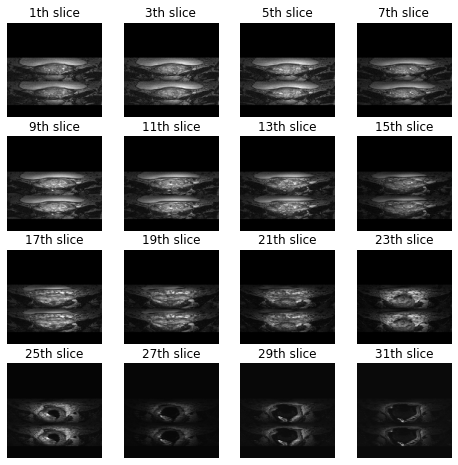

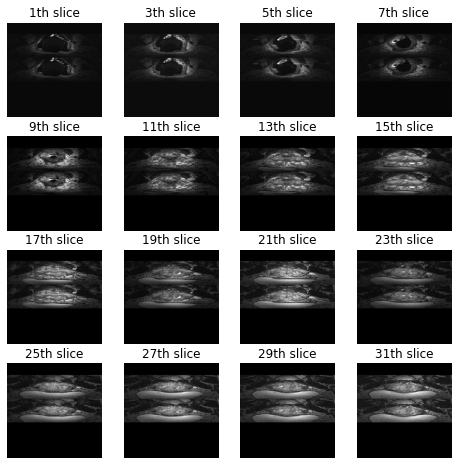

In [ ]:
import random
import numpy as np 
import matplotlib.pyplot as plt


def calculate_transform_matrix(a1, a2, a3, t1, t2, t3):# in degree
    a1, a2, a3 = np.deg2rad(a1), np.deg2rad(a2), np.deg2rad(a3)
    rigid_T, R_z, R_y, R_x = np.eye(4,4), np.eye(3,3), np.eye(3,3), np.eye(3,3)
    sinz, cosz, siny, cosy, sinx, cosx = np.sin(a1), np.cos(a1), np.sin(a2), np.cos(a2), np.sin(a3), np.cos(a3)
    # rotation around z-axis by 30 degrees
    R_z[0,0], R_z[0,1], R_z[1,0], R_z[1,1] = cosz, -sinz, sinz, cosz
    # rotation around y-axis by 60 degrees
    R_y[0,0], R_y[0,2], R_y[2,0], R_y[2,2] = cosy, siny, -siny, cosy
    R_x[1,1], R_x[1,2], R_x[2,1], R_x[2,2] = cosx, -sinx, sinx, cosx
    # final Rotation matrix 
    R = np.matmul(R_y, R_z)
    R = np.matmul(R_x, R)
    t = np.array([t1,t2,t3])
    R_inv = R.T
    t_inv = np.matmul(-R_inv,t)
    # Calculating extrinsic marix using rotation and translation
    rigid_T[:3,:3], rigid_T[:3,3] = R, t
    rigid_inv = np.eye(4,4)
    rigid_inv[:3,:3], rigid_inv[:3,3] = R_inv[:,:], t_inv # creating an inverse rigid transformation matrix to fill in the target image.
    return rigid_T, rigid_inv

def warp_3d(image, tform, warp_size):
    rot_centre = (np.array(warp_size)-1)/2 
    warp_img = np.ones(warp_size)# 
    ddf = np.ones((*warp_size,3))
    for z in range(warp_size[0]):
        for x in range(warp_size[1]):
            for y in range(warp_size[2]):
                kij_homo = np.array([[z-rot_centre[0], x-rot_centre[1], y-rot_centre[2], 1]]).T # each point rotate around warped image centre, homogenious coords convinient for computation
                mapped_z, mapped_x, mapped_y = np.matmul(tform, kij_homo).T[0][:3] + rot_centre
                ddf[z,x,y] = mapped_z-z, mapped_x-x, mapped_y-y  # dispacement of each voxel in 3 dimensions       
                try: warp_img[z, x, y] = image[int(mapped_z), int(mapped_x), int(mapped_y)]# inverse rigid transformation and fill in the target image
                    # warp_img[int(mapped_z), int(mapped_x), int(mapped_y)] = image[z, x, y]# this causes massive noise and strains
                    # The larger you make your target image, the less it will resemble the document in the source image
                    # there are some points in target image plane for which there is no mapping to source points on source image plane. 
                except: pass#print(z, y, x, mapped_z, mapped_x, mapped_y)# 
            
    return warp_img, ddf

image = np.load('/content/drive/MyDrive/ucl/image_train00.npy') #(32, 128, 128)
np.random.seed(42)
randomlist = [*random.sample(range(-25, 25), 3),*random.sample(range(-2, 2), 3)]
print("ramdom parameters:", randomlist)
rigid, rigid_inv = calculate_transform_matrix(randomlist[0], randomlist[1], randomlist[2],randomlist[3],randomlist[4],randomlist[5])
rigid, rigid_inv = calculate_transform_matrix(90,0,0,0,0,0)
# rigid_T_compose = np.matmul(rigid_T_compose, rigid)
# warp_image = warp_2d(image, 29, rigid_T, (128,128))
warp_volume, ddf = warp_3d(image, rigid, (32,128,128))
warp_volume_, ddf = warp_3d(image, rigid_inv, (32,128,128))


fig, ax = plt.subplots(4, 4, figsize=(8,8))
for i in range(16):
    ax.flatten()[i].imshow(warp_volume[i*2,:,:], cmap='gray'), ax.flatten()[i].set_title(str(i*2+1)+"th slice"), ax.flatten()[i].axis('off')
fig.show()
fig, ax = plt.subplots(4, 4, figsize=(8,8))
for i in range(16):
    ax.flatten()[i].imshow(warp_volume_[i*2], cmap='gray'), ax.flatten()[i].set_title(str(i*2+1)+"th slice"), ax.flatten()[i].axis('off')

fig.savefig('rigid_tform_vol', transparent=True)
plt.show()


In [ ]:
plt.subplot(111), plt.imshow(warp_volume[31], cmap='gray')
plt.savefig('[-2, -1, 5, 7, 8, -10][-1, 3, 8, -2, -3, 6]31', transparent=True)
plt.show()
plt.subplot(111), plt.imshow(warp_volume[29], cmap='gray')
plt.savefig('[-2, -1, 5, 7, 8, -10][-1, 3, 8, -2, -3, 6]29', transparent=True)
plt.show()
plt.subplot(111), plt.imshow(warp_volume[15], cmap='gray')
plt.savefig('[-2, -1, 5, 7, 8, -10][-1, 3, 8, -2, -3, 6]15', transparent=True)
plt.show()
plt.subplot(111), plt.imshow(warp_volume[21], cmap='gray')
plt.savefig('[-2, -1, 5, 7, 8, -10][-1, 3, 8, -2, -3, 6]21', transparent=True)


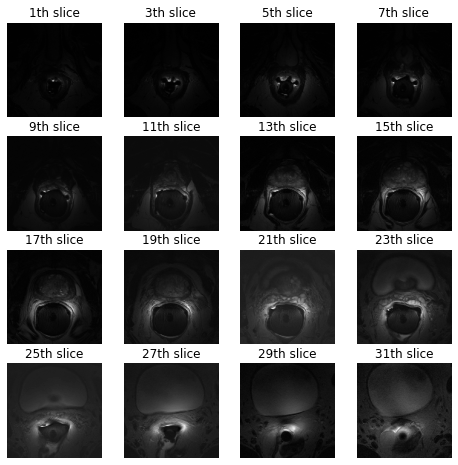

In [ ]:


image = np.load('/content/drive/MyDrive/ucl/image_train00.npy') #(32, 128, 128)

fig, ax = plt.subplots(4, 4, figsize=(8,8))
for i in range(16):
    ax.flatten()[i].imshow(image[i*2], cmap='gray'), ax.flatten()[i].set_title(str(i*2+1)+"th slice"), ax.flatten()[i].axis('off')

fig.savefig('task3_data', transparent=True)
plt.show()

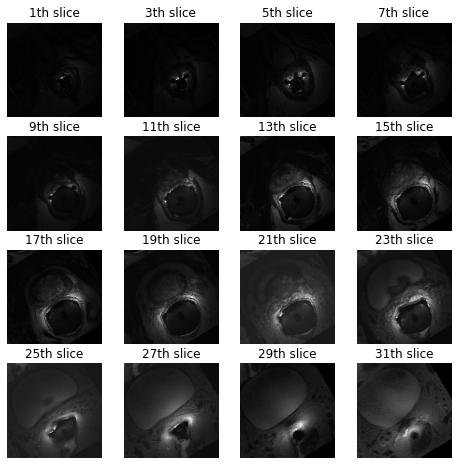

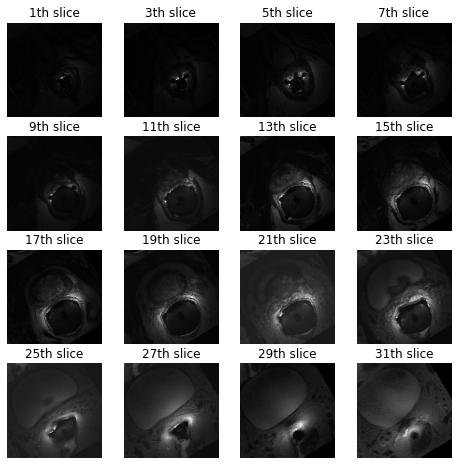

In [ ]:
from numpy.ma.core import transpose
from PIL import Image

def warp_2d(image, slice, tform, warp_size):
    centre = (np.array(image.shape)-1)/2 
    warp_img = np.ones(warp_size)
    for x in range(warp_size[0]):
        for y in range(warp_size[1]):
            ij_homo = np.array([x-centre[1], y-centre[2] , slice-centre[0], 1]).T
            mapped_x, mapped_y = np.matmul(tform, ij_homo).T[:2] + centre[1:3]
            try:
                warp_img[x, y] = image[slice][int(mapped_x), int(mapped_y)]# warp_img[y, x, :] = image[int(mapped_y), int(mapped_x), :]#RGB 3 channel
            except: pass#print(z, y, x, ddf)
    return warp_img

def warp_3d(image, tform, warp_size):
    rot_centre = (np.array(warp_size)-1)/2 
    warp_img = np.ones(warp_size)# 
    ddf = np.ones((*warp_size,3))
    for z in range(warp_size[0]):
        for x in range(warp_size[1]):
            for y in range(warp_size[2]):
                kij_homo = np.array([z-rot_centre[0], x-rot_centre[1], y-rot_centre[2], 1]).T # each point rotate around warped image centre, homogenious coords convinient for computation
                mapped_z, mapped_x, mapped_y = np.matmul(tform, kij_homo).T[:3] + rot_centre
                ddf[z,x,y] = mapped_z-z, mapped_x-x, mapped_y-y  # dispacement of each voxel in 3 dimensions       
                try: warp_img[z, x, y] = image[int(mapped_z), int(mapped_x), int(mapped_y)]# inverse rigid transformation and fill in the target image
                    # warp_img[int(mapped_z), int(mapped_x), int(mapped_y)] = image[z, x, y]# this causes massive noise and strains
                    # The larger you make your target image, the less it will resemble the document in the source image
                    # there are some points in target image plane for which there is no mapping to source points on source image plane. 
                except: pass#print(z, y, x, mapped_z, mapped_x, mapped_y)# 
            
    return warp_img, ddf

image = np.load('/content/drive/MyDrive/ucl/image_train00.npy') #(32, 128, 128)
rigid_T, rigid_T_inv = calculate_transform_matrix(30, 10, 10,0,0,0)

fig, ax = plt.subplots(4, 4, figsize=(8,8))
for i in range(16):
    warp_image = warp_2d(image, i*2, rigid_T_inv, (128,128))
    ax.flatten()[i].imshow(warp_image, cmap='gray'), ax.flatten()[i].set_title(str(i*2+1)+"th slice"), ax.flatten()[i].axis('off')
fig.savefig('rigid_tform', transparent=True)
plt.show()

fig, ax = plt.subplots(4, 4, figsize=(8,8))
for i in range(16):
    warp_image = warp_2d(image, i*2, rigid_T_inv, (128,128))
    ax.flatten()[i].imshow(warp_image, cmap='gray'), ax.flatten()[i].set_title(str(i*2+1)+"th slice"), ax.flatten()[i].axis('off')
fig.savefig('rigid_tform', transparent=True)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt


"""
Rigid transformation matrix 4x4 taking into account
   rotation and translation is given by
   [[R, O],
    [0, 1]]

  where R = Net Rotation matrix, O = Translation vector

Rotation matrix 3x3 about z-axis is given by 
  [[cosA, -sinA, 0],
   [sinA, cosA,  0],
   [0,     0,    1]] where A = angle of rotation

Rotation matrix 3x3 about y-axis is given by 
  [[cosA,   0,  sinA],
   [ 0,     1,   0  ],
   [-sinA,  0,  cosA]] where A = angle of rotation

Rotation matrix 3x3 about x-axis is given by 
  [[1,     0,      0],
   [0,  cosA,  -sinA],
   [0,  sinA,   cosA]] where A = angle of rotation
"""
def calculate_transform_matrix(a1, a2, a3, t1, t2, t3):# in degree
    a1, a2, a3 = np.deg2rad(a1), np.deg2rad(a2), np.deg2rad(a3)
    rigid_T, R_z, R_y, R_x = np.eye(4,4), np.eye(3,3), np.eye(3,3), np.eye(3,3)
    sinz, cosz, siny, cosy, sinx, cosx = np.sin(a1), np.cos(a1), np.sin(a2), np.cos(a2), np.sin(a3), np.cos(a3)
    # rotation around z-axis by 30 degrees
    R_z[0,0], R_z[0,1], R_z[1,0], R_z[1,1] = cosz, -sinz, sinz, cosz
    # rotation around y-axis by 60 degrees
    R_y[0,0], R_y[0,2], R_y[2,0], R_y[2,2] = cosy, siny, -siny, cosy
    R_x[1,1], R_x[1,2], R_x[2,1], R_x[2,2] = cosx, -sinx, sinx, cosx
    # final Rotation matrix 
    R = np.matmul(R_y, R_z)
    R = np.matmul(R_x, R)
    # Calculating extrinsic marix using rotation and translation
    rigid_T[:3,:3], rigid_T[2,3], rigid_T[2,3], rigid_T[2,3] = R[:,:], t1, t2, t3
    return rigid_T

# project 3D euclidian points to 2D euclidian 
def project_points(rigid_T1, rigid_T, pts):
    # convert first points to homogeneous coordinates
    pts_homo = to_homog(pts)
    # apply transformation using intrinsic and extrinsic matrix
    composed_T = np.matmul(rigid_T1, rigid_T)
    pts_proj = np.matmul(composed_T, pts_homo)
    # now convert them to eclidean coordinates
    pts_proj = from_homog(pts_proj)
    ddf = pts_proj-pts
    print(ddf)
    return pts_proj


# convert points from euclidian to homogeneous
def to_homog(points):
    ones = [1. for _ in range(points.shape[1])]
    # append 1. for all points as last coordinate
    points = np.append(points, [ones], axis=0)    
    return points


# convert points from homogeneous to euclidian
def from_homog(points_homog):
    # get all the last element for all homogeneous points
    w = points_homog[-1:][0]
    points_homog = np.delete(points_homog, -1, 0)

    # now divide each point with it's corresponding w
    for idx, wi in enumerate(w):
        points_homog[:, idx] /= wi
    
    return points_homog
        
    
def plot_points(points, title='', style='.-r', axis=[]):
    inds = list(range(points.shape[1]))+[0]
    plt.plot(points[0,inds], points[1,inds],style)
    for i in range(len(points[0,inds])):
        plt.annotate(str("{:.1f}".format( points[0,inds][i]))+",  "+str("{:.1f}".format( points[1,inds][i])),(points[0,inds][i], points[1,inds][i]))
    if title: plt.title(title)
    if axis: plt.axis(axis)
    plt.tight_layout()

def plot_points_3d(points, title='', style='.-r', axis=[]):
    idxs = list(range(points.shape[1]))+[0]# (5 items) [0, 1, 2, 3, 0]
    fig, ax = plt.subplots(subplot_kw =dict(projection="3d"))
    ax.plot(points[0,idxs], points[1,idxs], points[2,idxs])# points[0,[0, 1, 2, 3, 0]]# [-1.  1.  1. -1. -1.] go back to start point, form a closed shape
    ax.set_xlabel('x'), ax.set_ylabel('y'),ax.set_zlabel('z')
    # ax.view_init(35, 60)
    for i in range(4):
        ax.scatter(points[0,i],points[1,i],points[2,i])
        ax.text(points[0,i],points[1,i],points[2,i], "({:.1f}, {:.1f}, {:.1f})".format(points[0,i],points[1,i],points[2,i]))
    # plt.axis("off")
    if title: plt.title(title)
    if axis: plt.axis(axis)

[[ 0.40808206  0.91294525  0.          1.        ]
 [-0.91294525  0.40808206  0.          2.        ]
 [ 0.          0.          1.          3.        ]
 [ 0.          0.          0.          1.        ]]
[ 1.41780844 -1.72910937 -3.        ]
[[ 0.40808206 -0.91294525  0.          1.41780844]
 [ 0.91294525  0.40808206  0.         -1.72910937]
 [ 0.          0.          1.         -3.        ]
 [ 0.          0.          0.          1.        ]]


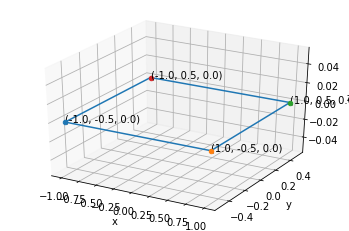

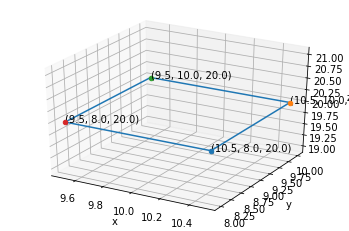

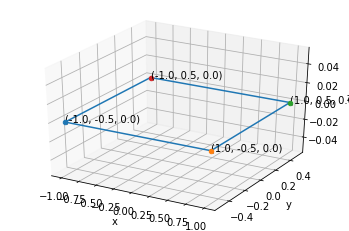

In [ ]:
import numpy as np

a1, a2, a3 = -20, 0 ,0 # in degree
rigid_T, R_z, R_y, R_x = np.eye(4,4), np.eye(3,3), np.eye(3,3), np.eye(3,3)
sinz, cosz, siny, cosy, sinx, cosx = np.sin(a1), np.cos(a1), np.sin(a2), np.cos(a2), np.sin(a3), np.cos(a3)
# rotation around z-axis by 30 degrees
R_z[0,0], R_z[0,1], R_z[1,0], R_z[1,1] = cosz, -sinz, sinz, cosz
# rotation around y-axis by 60 degrees
R_y[0,0], R_y[0,2], R_y[2,0], R_y[2,2] = cosy, siny, -siny, cosy
R_x[1,1], R_x[1,2], R_x[2,1], R_x[2,2] = cosx, -sinx, sinx, cosx
# final Rotation matrix 
R = np.matmul(R_y, R_z)
R = np.matmul(R_x, R)
# Calculating extrinsic marix using rotation and translation
rigid_T[:3,:3], rigid_T[:3,3] = R, [7, 2, 3]

t = np.eye( 4, 4)
t[:3, 3] = 1,2,3
Rot = np.eye(4,4)
Rot[:3,:3] = R
M = np.matmul(t, Rot)
print(M)

R_inv = Rot.T#np.transpose(Rot)
minusRt = np.matmul(-R_inv[:3,:3],t[:3, 3])
print(minusRt)
t_inv = np.eye( 4, 4)
t_inv[:3, 3] = minusRt
M_inv = np.matmul(t_inv,R_inv)
print(M_inv)

def calculate_transform_matrix(a1, a2, a3, t1, t2, t3):# rotation in the unit of degree, translation in the unit of voxel
    a1, a2, a3 = np.deg2rad(a1), np.deg2rad(a2), np.deg2rad(a3) # in degree
    rigid_T, R_z, R_y, R_x = np.eye(4,4), np.eye(3,3), np.eye(3,3), np.eye(3,3)
    sinz, cosz, siny, cosy, sinx, cosx = np.sin(a1), np.cos(a1), np.sin(a2), np.cos(a2), np.sin(a3), np.cos(a3)
    # rotation around z-axis by 30 degrees
    R_z[0,0], R_z[0,1], R_z[1,0], R_z[1,1] = cosz, -sinz, sinz, cosz
    # rotation around y-axis by 60 degrees
    R_y[0,0], R_y[0,2], R_y[2,0], R_y[2,2] = cosy, siny, -siny, cosy
    R_x[1,1], R_x[1,2], R_x[2,1], R_x[2,2] = cosx, -sinx, sinx, cosx
    # final Rotation matrix 
    R = np.matmul(R_y, R_z)
    R = np.matmul(R_x, R)
    t = np.array([t1,t2,t3])
    R_inv = R.T
    t_inv = np.matmul(-R_inv,t)
    # Calculating extrinsic marix using rotation and translation
    rigid_T[:3,:3], rigid_T[:3,3] = R, t
    rigid_inv = np.eye(4,4)
    rigid_inv[:3,:3], rigid_inv[:3,3] = R_inv[:,:], t_inv # creating an inverse rigid transformation matrix to fill in the target image.
    return rigid_T, rigid_inv
M, M_inv = calculate_transform_matrix(90,0,0,10,9,20)
###############
# plot
################
point1 = np.array([[-1,-.5, 0]]).T# (3, 1)
point2 = np.array([[1,-.5, 0]]).T
point3 = np.array([[1,.5, 0]]).T
point4 = np.array([[-1,.5, 0]]).T
original_points = np.hstack((point1,point2,point3,point4))# (3, 4)
points = from_homog(np.matmul(M, to_homog(original_points)))
original = from_homog(np.matmul(M_inv, to_homog(points)))
plot_points_3d(original_points)# plot_points(homo_points)
plot_points_3d(points)# plot_points(homog_transformed_points)
plot_points_3d(original)# plot_points(homog_transformed_points)

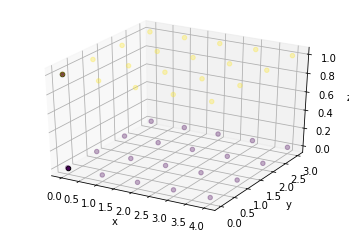

[2.  1.5 0.5]


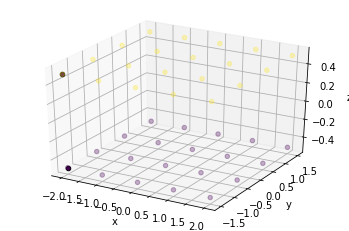

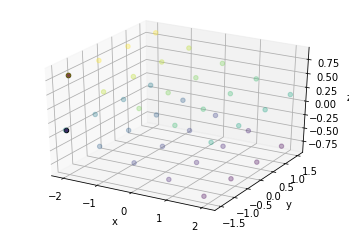

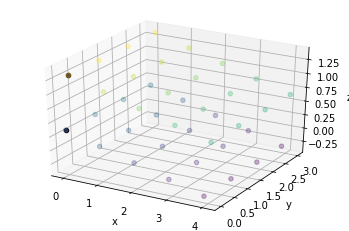

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def scatter(ijk):
    fig, ax = plt.subplots(subplot_kw =dict(projection="3d"))
    ax.scatter(ijk[0], ijk[1], ijk[2], c=ijk[2], alpha=0.3)
    ax.scatter(ijk[0][0,0,0], ijk[1][0,0,0], ijk[2][0,0,0], c=ijk[2][0,0,0], edgecolor = "black")
    ax.scatter(ijk[0][0,0,1], ijk[1][0,0,1], ijk[2][0,0,1], c=ijk[2][0,0,1], edgecolor = "black")
    # ax.scatter(i[1], j[1], k[1], c=k[1], edgecolor = "black")
    ax.set_xlabel('x'), ax.set_ylabel('y'),ax.set_zlabel('z')
    plt.show()


# image = np.load('/content/drive/MyDrive/ucl/image_train00.npy') #(32, 128, 128)
# centre = (np.array(image.shape[:][::-1])-1)/2 # [63.5 63.5 15.5]
shape = (5, 4, 2)
x, y, z = np.indices(shape)
xyz = np.array([x,y,z])# (3,shape)
scatter(xyz)

# displace to origin
centre = (np.array(shape[:])-1)/2 #[::-1]
print(centre)
centre = np.tile(centre, (*shape, 1)).transpose(3,0,1,2)
ijk = xyz-centre # coordinate w.r.t centre
scatter(ijk)

# # # rotate w.r.t centre
i,j,k = ijk[0].flatten(), ijk[1].flatten(), ijk[2].flatten()
homo_ijk = np.vstack((i,j,k,np.ones(len(i))))
rigid_T = calculate_transform_matrix(0, 10, 0,0,0,0)
tformed_ijk = np.matmul(rigid_T, homo_ijk)[:3,:].reshape(3,*shape)
scatter(tformed_ijk)

# displace back to original coord
tformed_xyz =  tformed_ijk + centre# coordinate w.r.t centre
ddf = tformed_xyz - xyz
scatter(tformed_xyz)
# warp_image[int(mapped_y), int(mapped_x), :] = source_img[y, x, :]


0.0 0.0 0.0
[[ 1. -1. -1.  1.]
 [ 0.  0.  0.  0.]
 [ 1. -1. -1.  1.]]


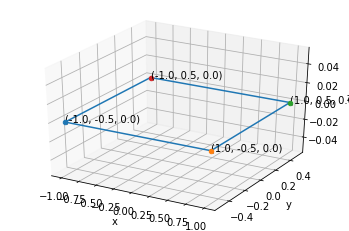

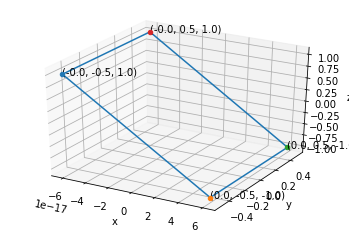

In [ ]:
point1 = np.array([[-1,-.5, 0]]).T# (3, 1)
point2 = np.array([[1,-.5, 0]]).T
point3 = np.array([[1,.5, 0]]).T
point4 = np.array([[-1,.5, 0]]).T
original_points = np.hstack((point1,point2,point3,point4))# (3, 4)
# [[-1.   1.   1.  -1. ]
#  [-0.5 -0.5  0.5  0.5]
#  [ 2.   2.   2.   2. ]]
homo_points =to_homog(original_points)
# [[-1.   1.   1.  -1. ]
#  [-0.5 -0.5  0.5  0.5]
#  [ 2.   2.   2.   2. ]
#  [ 1.   1.   1.   1. ]]
rigid_T = calculate_transform_matrix(0, 90,0,0,0,0)
# [[ 0.4330127 -0.25       0.8660254  0.       ]
#  [ 0.5        0.8660254  0.         0.       ]
#  [-0.75       0.4330127  0.5        1.       ]
#  [ 0.         0.         0.         1.       ]]
homog_transformed_points = np.matmul(rigid_T, homo_points)
# [[ 1.42403811  2.29006351  2.04006351  1.17403811]
#  [-0.9330127   0.0669873   0.9330127  -0.0669873 ]
#  [ 2.53349365  1.03349365  1.46650635  2.96650635]
#  [ 1.          1.          1.          1.        ]]
points = from_homog(homog_transformed_points)
print('centre after rotation: ' + sum(points[0]),sum(points[1]),sum(points[2]))
# [[ 1.42403811  2.29006351  2.04006351  1.17403811]
#  [-0.9330127   0.0669873   0.9330127  -0.0669873 ]
#  [ 2.53349365  1.03349365  1.46650635  2.96650635]]
ddf = points-original_points
print(ddf)
plot_points_3d(original_points)# plot_points(homo_points)
plot_points_3d(points)# plot_points(homog_transformed_points)

(<matplotlib.image.AxesImage at 0x7f2bede99430>,
 Text(0.5, 1.0, '30$^\\circ$'))

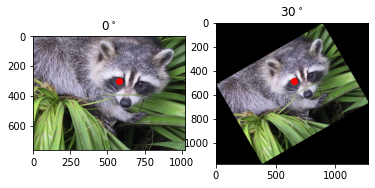

In [ ]:
from scipy import misc
from scipy.ndimage import rotate
from skimage.transform import resize

data_orig = misc.face() #ndarray (768, 1024, 3)
org_center = (np.array(data_orig.shape[:2][::-1])-1)/2. # ndarray (2,) ([1023  767])/2=[511.5 383.5] rotate aound this point in the following
x0,y0 = 580,300 # left eye coord with respect to left upper corner
org = np.array([x0,y0])-org_center # [ 68.5 -83.5] coord with respect to center
corners = np.array([[0,0], [0,data_orig.shape[0]-1], [data_orig.shape[0]-1,data_orig.shape[1]-1], [data_orig.shape[1]-1,0]])# (4,2)
corners_wrp_center = corners-org_center# shape (4, 2)-shape (2,) 

angle = 30
a = np.deg2rad(angle)
new = np.array([org[0]*np.cos(a) + org[1]*np.sin(a), -org[0]*np.sin(a) + org[1]*np.cos(a)])# [  17.57274016 -106.56312122] rotate point around the center of image
im_rot = rotate(data_orig, angle) #  (1177, 1271, 3) rotate image
rot_center = (np.array(im_rot.shape[:2][::-1])-1)/2.# [635. 588.]
(x1,y1) = new + rot_center # (652.5727401592341, 481.43687878399936) coord with respect to left upper corner of image rotated

fig,axes = plt.subplots(1,2)
axes[0].imshow(data_orig), axes[0].scatter(x0,y0,c="r"), axes[0].set_title("{}$^\circ$".format(0))
axes[1].imshow(im_rot), axes[1].scatter(x1,y1,c="r"), axes[1].set_title("{}$^\circ$".format(angle))

In [ ]:
def warp_3d(image, tform, warp_size):
    centre = (np.array(image.shape[:])-1)/2 #[15.5 63.5 63.5]
    warp_img = np.ones(warp_size)# 
    for z in range(warp_size[0]):
        for x in range(warp_size[1]):
            for y in range(warp_size[2]):
                ijk_homo = np.array([[z-centre[0], x-centre[1], y-centre[2], 1]]).T
                mapped_z, mapped_x, mapped_y = np.matmul(tform, ijk_homo).T[0][:3] + centre
                ddf = mapped_x-x, mapped_y-y, mapped_z-z          
                try: warp_img[z, x, y] = image[int(mapped_z), int(mapped_x), int(mapped_y)]# warp_img[y, x, :] = image[int(mapped_y), int(mapped_x), :]#RGB 3 channel
                # try: warp_img[z, y, x] = image[int(mapped_z), int(mapped_y), int(mapped_x)]# warp_img[y, x, :] = image[int(mapped_y), int(mapped_x), :]#RGB 3 channel
                except: pass#print(z, y, x, ddf)
            
    return warp_img

In [ ]:
def transformation_from_parameters(axisangle, translation, invert=False):
    """Convert the network's (axisangle, translation) output into a 4x4 matrix
    """
    R = rot_from_axisangle(axisangle)
    t = translation.clone()

    if invert:
        R = R.transpose(1, 2)
        t *= -1

    T = get_translation_matrix(t)

    if invert:
        M = torch.matmul(R, T)
    else:
        M = torch.matmul(T, R)

    return M

T = np.eye( 4, 4)
T[:3, 3] = 3
T
R = R.transpose(1, 2)
M_inv = torch.matmul(R, T)
M = torch.matmul(T, R)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[-7.70850152 -5.73888602 -8.08618237 -9.8821497 ]
 [-2.40860794 -0.34830056  1.96333509 -0.26798236]
 [ 1.33856724  0.9965471   1.40415083  1.71601729]]
[[-7.70850152 -5.73888602 -8.08618237 -9.8821497 ]
 [-2.40860794 -0.34830056  1.96333509 -0.26798236]
 [ 1.33856724  0.9965471   1.40415083  1.71601729]]
[[ 4.12534749  1.9820838  -0.3874784   2.07454098]
 [-6.29989358 -4.39058546 -7.04951746 -8.61416734]
 [ 0.38343115  0.42468382  1.31134303  1.15311257]]
[[-3.58315404 -3.75680221 -8.47366077 -7.80760872]
 [-8.70850152 -4.73888602 -5.08618237 -8.8821497 ]
 [ 1.72199839  1.42123092  2.71549386  2.86912986]]


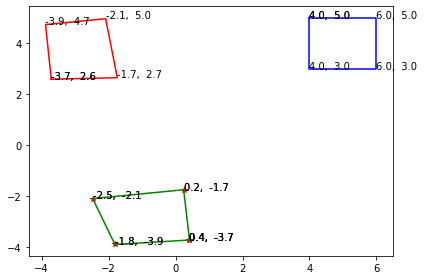

In [ ]:
point1 = np.array([[4, 5, 7]]).T# homogeneous coordinates of 2d point
point2 = np.array([[4, 3, 7]]).T
point3 = np.array([[6, 3, 5]]).T
point4 = np.array([[6, 5, 6]]).T
points = np.hstack((point1,point2,point3,point4))# horizontal

rigid_T = calculate_transform_matrix(90, 10,10,0,0,0)
rigid_T2 = calculate_transform_matrix(90, 20,0,0,0,0)

plot_points(project_points(np.eye(4,4), np.eye(4,4), points), style='b')
plot_points(project_points(np.eye(4,4), rigid_T, points), style='r')
plot_points(project_points(np.eye(4,4), rigid_T2, project_points(np.eye(4,4), rigid_T, points)), style='*r')# compose1
plot_points(project_points(rigid_T2, rigid_T, points), style='g')# compose2
plt.show()


[[ 7.85455111e-01 -1.46472235e-15  0.00000000e+00]
 [ 5.13478149e-16  4.80513715e-01 -3.28205345e-14]
 [ 7.75432359e-03 -4.32587969e-03  3.89984608e-01]]
[[ 3.59694608e-01  4.77701866e-16  0.00000000e+00]
 [ 2.35922393e-16  5.87962341e-01 -7.71908579e-15]
 [-7.15204735e-03  6.52193521e-03  7.24449023e-01]]
(3, 3)


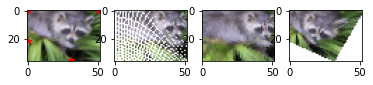

In [ ]:
from skimage.transform import resize
from scipy import misc

def computeH(source_points, target_points):
    # returns the 3x3 homography matrix such that:
    # np.matmul(H, source_points) ~ target_points
    # where source_points and target_points are expected to be in homogeneous
    
    # Please refer the note on DLT algorithm given at: 
    # https://cseweb.ucsd.edu/classes/wi07/cse252a/\
    # homography_estimation/homography_estimation.pdf
    
    # make sure points are 3D homogeneous
    assert source_points.shape[0]==3 and target_points.shape[0]==3
    
    # Calculate A matrix using given source and target points and then 
    # solve equation Ah = 0, using SVD algorithm that will give V matrix.
    # H(Homography matrix) is 3x3 reshape of last column of matrix V
    A = []
    for i in range(0, source_points.shape[1]):
        x1, y1, _ = source_points[:, i]
        x2, y2, _ = target_points[:, i]
        A.append([-x1, -y1, -1, 0, 0, 0, x2*x1, x2*y1, x2])
        A.append([0, 0, 0, -x1, -y1, -1, y2*x1, y2*y1, y2])
        
    A = np.asarray(A)
    
    U, S, V = np.linalg.svd(A)
    # Note SVD in numpy gives transpose of V, not actual V matrix
    # So we will do transpose to get V matrix
    H = V.T[:,-1].reshape(3, 3)
    
    return H

def warp(source_img, source_points, target_size):

    # selecting the corner points in the target image
    target_points = np.vstack(([0, 0, target_size[1]-1, target_size[1]-1], [0, target_size[0]-1, target_size[0]-1, 0]))

    target_image = np.ones(target_size) / 1.
    
    H = computeH(to_homog(source_points), to_homog(target_points))
    print(H)
    # Now map the points from source to target and 
    # fill the pixel values in target image
    # x' = Hx
    for x in range(source_img.shape[1]):# left upper corner is origin 
        for y in range(source_img.shape[0]):
            mapped_x, mapped_y = from_homog(np.matmul(H,to_homog(np.array([[x], [y]])))).T[0]
            
            if (0 <= mapped_x <= target_size[1]) and (0 <= mapped_y <= target_size[0]):
                # Map only points in source image for which calculated 
                # target points lie on targe image plane
                target_image[int(mapped_y), int(mapped_x), :] = source_img[y, x, :]
    
    # playing with interpolation, trying to remove noise
    target_image = resize(target_image, target_size)
    return target_image

def warp2(source_img, source_points, target_size):

    # create an empty target image which we will starti filling 
    target_image = np.ones(target_size) / 1.
    
    # selecting the corner points in the target image
    target_points = np.vstack(([0, 0, target_size[1]-1, target_size[1]-1], [0, target_size[0]-1, target_size[0]-1, 0]))
    
    # compute H 
    H_inv = computeH(to_homog(target_points), to_homog(source_points))
    print(H_inv)
    # Now map the points from target to source and 
    # fill the pixel values in target image
    # x' = Hx
    for x in range(target_image.shape[1]):
        for y in range(target_image.shape[0]):
            # print(x,y)
            # convert to homogeneous coordinate
            xy_homo = to_homog(np.array([[x, y]]).T)
            # print(xy_homo)
            # apply homography
            mapped_x, mapped_y = from_homog(np.matmul(H_inv,xy_homo)).T[0]
            target_image[y, x, :] = source_img[int(mapped_y), int(mapped_x), :]    
    return target_image

def warp3(source_img, source_points, target_size):

    # create an empty target image which we will starti filling 
    target_image = np.ones(target_size) / 1.
    
    # selecting the corner points in the target image
    target_points = np.vstack(([0, 0, target_size[1]-1, target_size[1]-1], [0, target_size[0]-1, target_size[0]-1, 0]))
    
    # compute H 
    H_inv = computeH(to_homog(target_points), to_homog(source_points))
    H_inv = computeH( to_homog(source_points), to_homog(target_points))#.T

    print(H_inv.shape)
    # Now map the points from target to source and 
    # fill the pixel values in target image
    # x' = Hx
    for x in range(target_image.shape[1]):
        for y in range(target_image.shape[0]):
            xy_homo = to_homog(np.array([[x, y]]).T)
            mapped_x, mapped_y = from_homog(np.matmul(H_inv,xy_homo)).T[0]
            try: target_image[y, x, :] = source_img[int(mapped_y), int(mapped_x), :]
            except: pass
    return target_image

reshape_size = (36,52,3)# save time during debugging
image = resize(misc.face(), reshape_size) #(768, 1024, 3)#print(source_image.min(), source_image.max())# 0.023529411764705882 0.9483660130718956
source_points = np.vstack(([0,0,image.shape[1]/5*3,image.shape[1]-1],[0,image.shape[0]/5*3,image.shape[0]-1,0]))# left upper, counter clockwise
result1 = warp(image, source_points, reshape_size)#rigid_T[:3,:3]
result2 = warp2(image, source_points, reshape_size)#rigid_T[:3,:3]
result3 = warp3(image, source_points, reshape_size)#rigid_T[:3,:3]

fig, axes = plt.subplots(1,4)
axes[0].imshow(image), axes[0].plot(source_points[0], source_points[1], '*r')
axes[1].imshow(result1)
axes[2].imshow(result2)
axes[3].imshow(result3)

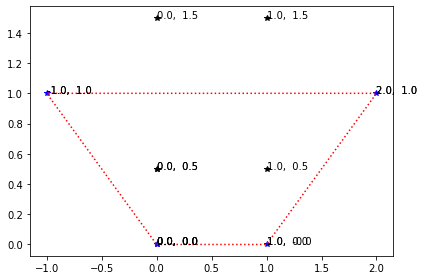

In [ ]:
def test_computeH():
    source_points = np.array([[0,0.5],[1,0.5],[1,1.5],[0,1.5]]).T
    target_points = np.array([[0,0],[1,0],[2,1],[-1,1]]).T
    H = computeH(to_homog(source_points), to_homog(target_points))
    mapped_points = from_homog(np.matmul(H,to_homog(source_points)))

    plot_points(source_points,style='*k')
    plot_points(target_points,style='*b')
    plot_points(mapped_points,style=':r')
    plt.show()
test_computeH()

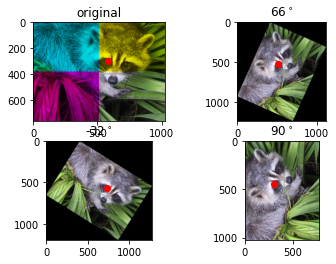

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc
from scipy.ndimage import rotate
import copy

data_orig = misc.face()
x0,y0 = 580,300 # left eye; (xrot,yrot) should point there

def rot(image, xy, angle):
    im_rot = rotate(image,angle) 
    org_center = (np.array(image.shape[:2][::-1])-1)/2.
    rot_center = (np.array(im_rot.shape[:2][::-1])-1)/2.
    org = xy-org_center
    a = np.deg2rad(angle)
    new = np.array([org[0]*np.cos(a) + org[1]*np.sin(a),
            -org[0]*np.sin(a) + org[1]*np.cos(a) ])
    return im_rot, new+rot_center

def vectorized(img):
    
    image = copy.deepcopy(img)
    a = int(image.shape[0]/2)
    b = int(image.shape[1]/2)
    image[:a,:b] = image[:a,:b]*[0,1,1]
    image[a:,:b] = image[a:,:b]*[1,0,1]
    image[:a,b:] = image[:a,b:]*[1,1,0]
    
    return image
data_v = vectorized(data_orig)    

fig,axes = plt.subplots(2,2)

axes[0,0].imshow(data_v)
axes[0,0].scatter(x0,y0,c="r")
axes[0,0].set_title("original")

for i, angle in enumerate([66,-32,90]):
    data_rot, (x1,y1) = rot(data_orig, np.array([x0,y0]), angle)# rotate image and point
    axes.flatten()[i+1].imshow(data_rot)
    axes.flatten()[i+1].scatter(x1,y1,c="r" )
    axes.flatten()[i+1].set_title("{}$^\circ$".format(angle))

plt.show()

In [ ]:
def plot_optical_flow(img,U,V):
    '''
    Plots optical flow given U,V and one of the images
    '''
    
    # Change t if required, affects the number of arrows
    # t should be between 1 and min(U.shape[0],U.shape[1])
    t=10 
    
    # Subsample U and V to get visually pleasing output
    U1 = U[::t,::t]
    V1 = V[::t,::t]
    
    # Create meshgrid of subsampled coordinates
    r, c = img.shape[0],img.shape[1]
    cols,rows = np.meshgrid(np.linspace(0,c-1,c), np.linspace(0,r-1,r))
    cols = cols[::t,::t]
    rows = rows[::t,::t]
    
    # Plot optical flow
    plt.figure(figsize=(8,8))
    plt.imshow(img)
    plt.quiver(cols,rows,U1,V1)
    plt.show()

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/a8e16f4967571b7a572d1a19f3f6468512f9843e" height=95>

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/234c5831df9d48e5dc4a1cc130475d3426a64ce1" height=95>


In [ ]:
rigid_para = [0,0,0,1,1,0]
c4, c5, c6 = np.cos(rigid_para[3]), np.cos(rigid_para[4]), np.cos(rigid_para[5])
s4, s5, s6 = np.sin(rigid_para[3]), np.sin(rigid_para[4]), np.sin(rigid_para[5])
tran_vector = np.array([[c5*c6,           c5*s6,              s5],
                        [-s4*s5*c6-c4*s6, -s4*s5*s6+c4*c6,  s4*c5],
                        [-c4*s5*c6+s4*s6, -c4*s5*s6-s4*c6,  c4*c5]])
tran_vector = np.array([[c5*c6,           c5*s6,              0],
                        [-s4*s5*c6-c4*s6, -s4*s5*s6+c4*c6,  0],
                        [0, 0,  1]])

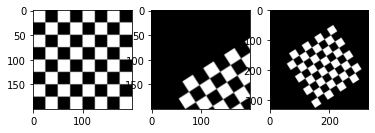

In [ ]:
import skimage
import matplotlib.pyplot as plt

checkerboard_image = skimage.data.checkerboard()
plt.subplot(131), plt.imshow(checkerboard_image, cmap='gray')

# warped_image = skimage.transform.warp(checkerboard_image, tran_vector)
# plt.subplot(142), plt.imshow(warped_image, cmap='gray')

tform = skimage.transform.AffineTransform(rotation=1,translation=(210, 50))
warped_image = skimage.transform.warp(checkerboard_image, tform.inverse)#, output_shape=(230, 230))
plt.subplot(132), plt.imshow(warped_image, cmap='gray')


tform = skimage.transform.AffineTransform(rotation=1,translation=(210, 50))#Translation parameters for each axis.
warped_image = skimage.transform.warp(checkerboard_image, tform.inverse, output_shape=(330, 330))
plt.subplot(133), plt.imshow(warped_image, cmap='gray')
tform = skimage.transform.AffineTransform(scale=(1.3, 1.1), rotation=1, shear=0.7,translation=(210, 50))

# Task 1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import marching_cubes


def surface_dividing(tri_surf, saggital_plane):
    """
    Take a list of verts and faces and a sagittal plane. Return left and right mesh cut by the plane. 
    - 1 : one or two of the triangle's vertices lies on the plane (so it just "touches" the plane without really intersecting)
    - 2 : the plane slice the triangle in two parts (either vertex-edge, vertex-vertex or edge-edge)
    Args:
        tri_surf (list of 2 items): a list of verts (array (M, 3)) and faces (array (N, 3))
        sagi_plane (int): represent a plane
    Returns:
        left (list of 2 items): a list of verts (array (M, 3)) and faces (array (N, 3))
        right (list of 2 items): a list of verts (array (M, 3)) and faces (array (N, 3))
    """
    verts, faces = tri_surf
    # classify verts into right and left first
    verts_l = np.array([v for v in verts if v[0] <= saggital_plane])
    verts_r = np.array([v for v in verts if v[0] >= saggital_plane])
    faces_l, faces_r = [], []
    new_faces_l, new_faces_r = [], []
    # then classify each face by the classification of its 3 verts
    for face in faces:# for each face, classify its verts into right and left
        face_l, face_r  = [], []
        for i,vert_id in enumerate(face):# this vert_id represent its index in all verts 
            # match the same vert coordinates in all verts with its index in classified verts
            face_l += [i for i,v in enumerate(verts_l) if (verts[vert_id] == v).all()] 
            face_r += [i for i,v in enumerate(verts_r) if (verts[vert_id] == v).all()]          
        lens = [len(face_l), len(face_r)]
        # because here consider points on the plane fall into both sides of verts so
        # lens can have 6 situations: [3,3][3,2][2,3][2,2][2,1][1,2] in normal situations

        # greater than 3, [1,0] [2,0] [0,0] throw error
        if lens[0]>3 or lens[1]>3 or sum(lens) < 3: raise Exception("bug found")

        # no itersection happens
        # 3,3: 3 points fall on plane, no itersection
        # 3,2: 2 points fall on plane, no intersection
        # 3,1: 1 point falls on plane, no intersection
        # 3,0: no point on plane, no itersection
        #  ____ no intersetion
        #  \  / 
        #   \/
        #  -----
        if len(face_l) == 3: faces_l.append(face_l)   
        if len(face_r)==3: faces_r.append(face_r)

        # intersection happens
        # 2,1 or 1,2: 
        #    ____     no poit on plane, 2 intersections i1 and i2
        # _i1\__/i2_
        #     \/
        if lens == [1, 2]: # 1 vertex on left side 2 verts on right side
            intersections1 = compute_intersection(verts_r[face_r[0]], verts_l[face_l[0]], saggital_plane)
            intersections2 = compute_intersection(verts_r[face_r[1]], verts_l[face_l[0]], saggital_plane)
            new_faces_r.append([face_r[0], face_r[1], intersections1])# r idx, r idx, coord to be added
            new_faces_r.append([face_r[0], face_r[1], intersections2])# e.g. [2780, [7.25, 29.0, 67.0], [7.25, 29.125, 67.5]]
            new_faces_l.append([face_l[0], intersections1, intersections2])# l idx, coord, coord
        if lens == [2, 1]: # 2 on left side and 1 vertex on right side 
            intersection1 = compute_intersection(verts_r[face_r[0]], verts_l[face_l[0]], saggital_plane)
            intersection2 = compute_intersection(verts_l[face_l[1]], verts_r[face_r[0]], saggital_plane)
            new_faces_r.append([face_r[0], intersection1, intersection2] )
            new_faces_l.append([face_l[0], face_l[1], intersection1])
            new_faces_l.append([face_l[0], face_l[1], intersection2])
  
  
        # intersection happens
        # 2,2: 
        # __i___    1 intersection i
        # \ | /
        #  \|/ 
        #   v      1 vertex v falls on the plane
        if lens == [2, 2]: # 1 on each side and 1 on the plane
            face_r_on_plane = [f for f in face_r if verts_r[f][0]==saggital_plane][0]
            face_r_not = [f for f in face_r if verts_r[f][0]!=saggital_plane][0]
            face_l_on_plane = [f for f in face_l if verts_l[f][0]==saggital_plane][0]
            face_l_not = [f for f in face_l if verts_l[f][0]!=saggital_plane][0]
            intersection = compute_intersection(verts_l[face_l_not],verts_r[face_r_not], saggital_plane)# 2 not on plane
            new_faces_r.append([face_r_not, face_r_on_plane, intersection]) # not_on_plane, on_plane, intersection
            new_faces_l.append([face_l_not, face_l_on_plane, intersection]) # e.g. [2500, 2917, [7.25, 16.75, 115.0]]
            new_faces_r.append([face_r_not, face_r_on_plane, intersection])
    print("divide triangulated mesh with x={}: \n\tgot {} triangles on the left and {} triangles on the right".format(saggital_plane, len(faces_l), len(faces_r)))   
    verts_l = form_new_faces(new_faces_l, verts_l, faces_l)
    verts_r = form_new_faces(new_faces_r, verts_r, faces_r)
    print("\t{} triangles on the left and {} triangles on the right in the end.".format(len(faces_l), len(faces_r)))
    return [verts_l, np.array(faces_l)], [verts_r, np.array(faces_r)]


def compute_intersection(p1, p2, saggital_plane):
    """
    To compute the point coordinate where the plane intersection with the line connection 2 points
    Symmetric Form:
        x−x0/a = y−y0/b = z−z0/c     
        (x-p1[0])/vector[0] = (y-p1[1])/vector[1] = (z-p1[2])/vector[2]
        These are basically the equations that result from the three components of vector form.
    Args:
        p1 (3 item list): [x,y,z], the coordinate of the point on one side of the saggital plane
        p2 (3 item list): [x,y,z], the coordinate of another point on the other side of the saggital plane
    return:
        intersection point (3 item list): represents the coordinate of the point where the plane intersection with the line connection 2 points
    """
    vector = p2 - p1
    x = saggital_plane
    y = (x-p1[0])/vector[0]*vector[1]+p1[1]
    z = (x-p1[0])/vector[0]*vector[2]+p1[2]
    return [x,y,z]

def form_new_faces(new_faces, verts, faces):
    print("\t" + str(len(new_faces) + " new triangles formed"))
    for face in new_faces:# [2894, 2999, [7.25, 34.625, 100.5]]
        for i,vert in enumerate(face):
            if type(vert)==list:       
                verts = np.vstack((verts,vert))
                face[i] = verts.shape[0]-1
        faces.append(face)
    return verts
    

divide triangulated mesh with x=5.25: got 2725 triangles on the left and 10490 triangles on the right
no of new faces: 193
no of new faces: 218
2918 triangles on the left and 10708 triangles on the right
max x coord of left: 5.25    min x coord of right : 5.25
divide triangulated mesh with x=7.25: got 5835 triangles on the left and 7227 triangles on the right
no of new faces: 300
no of new faces: 354
6135 triangles on the left and 7581 triangles on the right
max x coord of left: 7.25    min x coord of right : 7.25
divide triangulated mesh with x=10.25: got 10720 triangles on the left and 2782 triangles on the right
no of new faces: 25
no of new faces: 32
10745 triangles on the left and 2814 triangles on the right
max x coord of left: 10.25    min x coord of right : 10.25


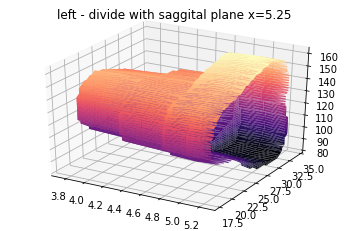

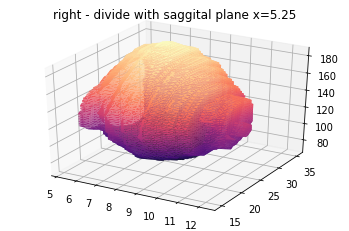

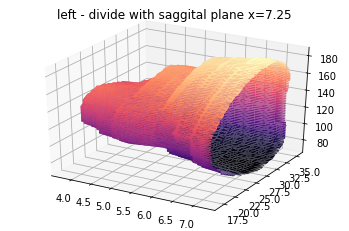

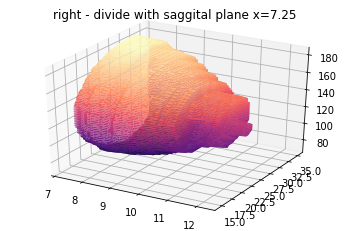

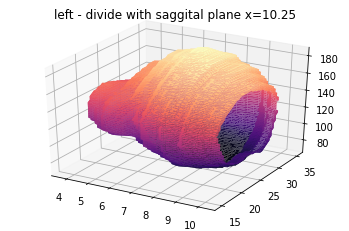

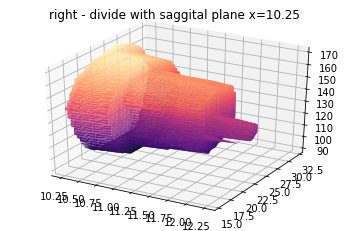

In [ ]:
label_array = np.load('/content/drive/MyDrive/ucl/label_train00.npy') #(32, 128, 128)

for i,plane in enumerate([5.25,7.25,10.25]):#case1, case2, case3 5.25, 7.25, 10.25
    verts, faces, normals, values = marching_cubes(label_array, spacing=(0.5,0.5,2)) # verts(6626, 3) faces(13248, 3)
    surface = [verts, faces]  
    saggital_scalar = plane # greater than 3.75 and less than 12.25

    left, right = surface_dividing(surface, saggital_scalar)
    print("\tmax x coord of left: {}    min x coord of right : {}".format(left[0][:,0].max(), right[0][:,0].min()))
    
    #plot and save
    fig, ax = plt.subplots(subplot_kw =dict(projection="3d"))
    fig1, ax1 = plt.subplots(subplot_kw =dict(projection="3d"))    
    ax.plot_trisurf(left[0][:, 0], left[0][:,1], left[0][:, 2],  triangles=left[1], cmap='magma'), ax.set_title("left - divide with saggital plane x="+str(plane))    
    ax1.plot_trisurf(right[0][:, 0], right[0][:,1], right[0][:, 2],  triangles=right[1], cmap='magma'), ax1.set_title("right - divide with saggital plane x="+str(plane))
    fig.savefig('case{}_left'.format(i), transparent=True)
    fig1.savefig('case{}_right'.format(i), transparent=True)
    # for angle in range(160, 360):
    #    ax.view_init(35, angle)
    #    plt.draw()
      #  plt.pause(.001)

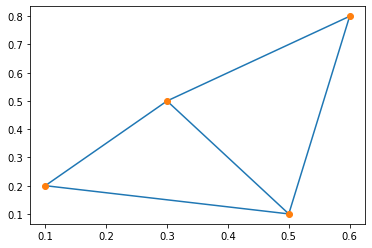

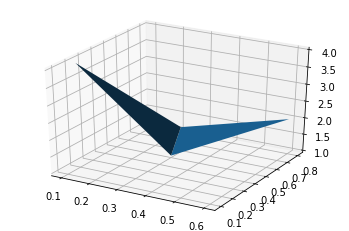

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
# 4 points
xy = [[0.3,0.5],# index 0
      [0.6,0.8],# index 1
      [0.5,0.1],# index 2
      [0.1,0.2]]# index 3
xy = np.array(xy)
# 4 points form 2 triangles
triangles = [[0,1,2],
             [0,2,3]]
triang = mtri.Triangulation(xy[:,0], xy[:,1], triangles=triangles)
plt.triplot(triang, marker="o")
plt.show()

z = [1, 2, 3, 4]
fig, ax = plt.subplots(subplot_kw =dict(projection="3d"))
ax.plot_trisurf(triang, z)

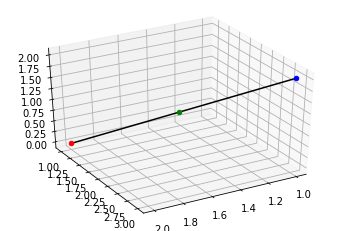

In [ ]:
import numpy as np

p1 = np.array([1, 3, 2])
p2 = np.array([2, 1, 0])
def compute_intersections(p1, p2, saggital_plane):
    vector = p2 - p1
    # (x-p1[0])/vector[0] = (y-p1[1])/vector[1] = (z-p1[2])/vector[2]
    x = saggital_plane
    y = (x-p1[0])/vector[0]*vector[1]+p1[1]
    z = (x-p1[0])/vector[0]*vector[2]+p1[2]
    return [x,y,z]
x,y,z=compute_intersections(p1,p2, 1.5)
ax = plt.figure().add_subplot(111, projection = '3d')
ax.scatter(p1[0], p1[1], p1[2], color = 'b')
ax.scatter(p2[0], p2[1], p2[2], color = 'r')
ax.scatter(x, y, z, color = 'g')
ax.plot([p1[0],p2[0]], [p1[1],p2[1]], [p1[2],p2[2]], 'k')
ax.view_init(35, 60)


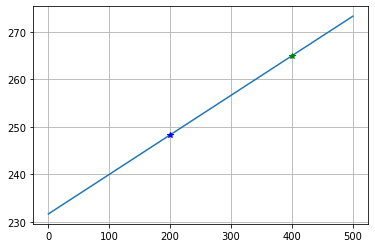

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the known points
x = [100, 400]
y = [240, 265]
z = [200, 300]
# Calculate the coefficients. This line answers the initial question. 
coefficients = np.polyfit(x, y, 1)#coefficients[0] coefficients[1]
polynomial = np.poly1d(coefficients)
x_axis = np.linspace(0,500,100)
y_axis = polynomial(x_axis)

# ...and plot the points and the line
plt.plot(x_axis, y_axis)
plt.plot( 200, polynomial(200), 'b*')
plt.plot( x[1], y[1], 'g*')
plt.grid('on')
plt.show()

In [ ]:
# https://github.com/julienr/meshcut


# Task 2

In [ ]:
from scipy.interpolate import interpn
from scipy.ndimage import gaussian_filter
import numpy as np
import matplotlib.pyplot as plt
import time

class Image3D():
    """
    handle 3D medical images with different voxel dimensions, image sizes and data types.
    """

    def __init__(self, image, voxel_dimension):
        """
        Build a local coordinate system to define the position of voxels, in a way that is specific to the image. 
        The origin of the local coordinate system is placed at the center of the image 
        and the axes are aligned with the dimensions of the image.
        Args:
            image (narray): a 3D image 
            voxel_dimension (tuple of three numerical items):  voxel dimension
        local image coordinate system:
          image size, the origin is at , Pre-compute the voxel coordinates in the constructor function.
                origin o
                  o +----> axis0    slice
                   /|
            axis1 / |           axial    orientation
                 L  |
                    v
                  axis2

        """
        
        shape = image.shape
        z = np.linspace(0, shape[0]-1, shape[0])# in the unit of voxel
        x = np.linspace(0, shape[1]-1, shape[1])
        y = np.linspace(0, shape[2]-1, shape[2])
        voxel_dimension = np.array(voxel_dimension)
        self.image_size = shape * voxel_dimension # in the unit of mm
        self.shape = shape # in the unit of voxel
        self.vol_coord = (z,x,y) 
        self.image = image
    
    def volume_resize(self, resize_ratio):
        """
        Args:
            resize_ratio (tuple of three numerical items):  resize ratio
        Return:
            interpolated image (narray):  (can be upsampled or downsampled)          
        """
        #resized image size should be the original image size multiple by this ratio
        new_dimen = (self.shape * np.array(resize_ratio)).astype(int)
        # print(new_dimen)
        new_z = np.linspace(0, self.shape[0]-1, new_dimen[0])
        new_x = np.linspace(0, self.shape[1]-1, new_dimen[1])
        new_y = np.linspace(0, self.shape[2]-1, new_dimen[2])
        new_z, new_x, new_y = np.meshgrid(new_z, new_x, new_y)        
        interped = interpn(self.vol_coord, self.image, (new_z,new_x,new_y))
        return interped

    def volume_resize_antialias(self, resize_ratio, std_deviation):
        """
        apply gaussian filter and then do interpolation
        Args:
            sigma scalar or sequence of scalars
            Standard deviation for Gaussian kernel. The standard deviations of the Gaussian filter are given for each axis as a sequence, or as a single number, in which case it is equal for all axes.
        Return:
            interpolated image (narray):  (can be upsampled or downsampled)   
        """
        # standard deviation in mm for specifying a Gaussian filter
        image = gaussian_filter(self.image, sigma=std_deviation)
        new_dimen = (self.shape * np.array(resize_ratio)).astype(int)
        new_z = np.linspace(0, self.shape[0]-1, new_dimen[0])
        new_x = np.linspace(0, self.shape[1]-1, new_dimen[1])
        new_y = np.linspace(0, self.shape[2]-1, new_dimen[2])
        new_z, new_x, new_y = np.meshgrid(new_z, new_x, new_y)        
        interped = interpn(self.vol_coord, image, (new_z,new_x,new_y))

        return interped

values = np.load('/content/drive/MyDrive/ucl/image_train00.npy') # (32, 128, 128)
# volumetric image with an axial in-plane pixel spacing of 0.5 mm/voxel and a slice distance of 2 mm/voxel. 
# voxel coordinates: 32 voxels * 128 voxels * 128 voxels
# size: 64mm * 64mm * 64mm  image_size = voxel_xyz*[2, 0.5, 0.5] in the unit of mm

# specifying a Gaussian filter sigma
sigma = 0.7

##############
# experiment 1
##############
img3d = Image3D(values, [2, 0.5, 0.5])
# time the two functions
# up-sampling
start = time.time()
upsample = img3d.volume_resize((5,5,5)).transpose(0,2,1)
end = time.time()
dur_up = end-start

#up-sampling with filter
start = time.time()
upsample_filter = img3d.volume_resize_antialias((5,5,5),sigma).transpose(0,2,1)
end = time.time()
dur_up_filter = end-start

#dwown-sampling without filter
start = time.time()
downsample = img3d.volume_resize((0.25,0.25,0.25)).transpose(0,2,1)
end = time.time()
dur_down = end-start

#down-sampling with filter
start = time.time()
downsample_filter = img3d.volume_resize_antialias((0.25,0.25,0.25),sigma).transpose(0,2,1)
end = time.time()
dur_down_filter = end-start

# isotropic voxel dimension:  
# uniform resolution in all directions, when the length, width and height are identical, the voxel is isotropic
# to make 0.5mm isotropic: 0.5mm*0.5mm*0.5mm, we need to add 3 slices between each 2 slices, 94,128,128
# in-plane dimension stays the same, resize_ratio=(2,1,1)
img3d_iso = Image3D(values, [1, 1, 1])

start = time.time()
isosample = img3d.volume_resize((4,1,1)).transpose(0,2,1)
end = time.time()
dur_iso = end-start

start = time.time()
isosample_filter = img3d.volume_resize_antialias((3,1,1),sigma).transpose(0,2,1)
end = time.time()
dur_iso_filter = end-start

print("time difference for up-sampling (difference between time including filtering and without filtering): {}\n\t\tfor down-sampling: {}\n\t\t for isotropic: {}".format(dur_up_filter-dur_up, dur_down_filter-dur_down, dur_iso_filter-dur_iso))
# The smaller the pixel size, the greater the image spatial resolution.

##############
# experiment 2
##############

img3d_exp2 = Image3D(upsample.transpose(2,0,1), [2, 0.5, 0.5])#  (320, 320, 320)
# upsample without filtering the downsampled image from experiment 1
exp2downsample = img3d_exp2.volume_resize((0.2,0.2,0.2)).transpose(0,2,1)
# upsample with filtering the downsampled image from experiment 1
exp2downsample_filter = img3d_exp2.volume_resize_antialias((0.2,0.2,0.2),sigma).transpose(0,2,1)

# compute mean and standard deviation of the voxel-level intensity differences between the original image and the down-sampled images
mean_diff = np.mean(values) - np.mean(exp2downsample)
mean_diff_filter = np.mean(values) - np.mean(exp2downsample_filter)
deviation_diff = np.std(values) - np.std(exp2downsample)
deviation_diff_filter = np.std(values) - np.std(exp2downsample_filter)
print("mean of the voxel-level intensity differences between the original image and the down-sampled images using the volume resizing function without filter:\n\t", mean_diff)
print("mean of the voxel-level intensity differences between the original image and the down-sampled images using the volume resizing function with filter:\n", mean_diff_filter)
print("standard deviation of the voxel-level intensity differences between the original image and the down-sampled images using the volume resizing function without filter:\n\t", deviation_diff)
print("standard deviation of the voxel-level intensity differences between the original image and the down-sampled images using the volume resizing function with filter:\n\t", deviation_diff_filter)





time difference for up-sampling (difference between time including filtering and without filtering): -12.844558954238892
		for down-sampling: 0.01894855499267578
		 for isotropic: -0.3389856815338135
mean of the voxel-level intensity differences between the original image and the down-sampled images using the volume resizing function without filter:
 0.06243892590083533
mean of the voxel-level intensity differences between the original image and the down-sampled images using the volume resizing function with filter:
 0.03312813617230859
standard deviation of the voxel-level intensity differences between the original image and the down-sampled images using the volume resizing function without filter:
 8.628347976997532
standard deviation of the voxel-level intensity differences between the original image and the down-sampled images using the volume resizing function with filter:
 14.301118016377075


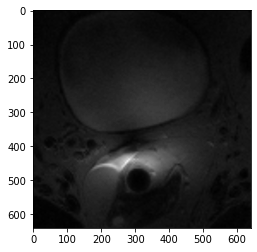

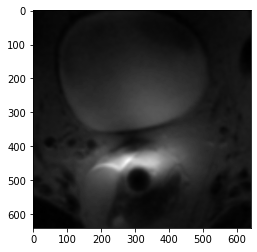

<ipython-input-2-08a24a92ba62>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(111), plt.imshow(isosample[:,:,slice], cmap='gray')


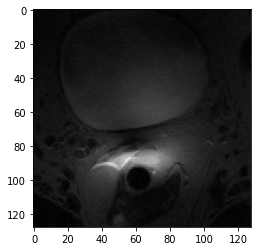

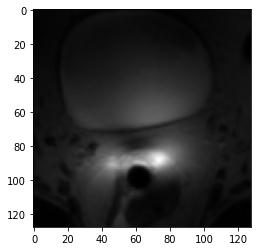

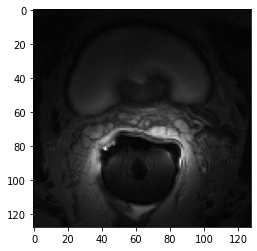

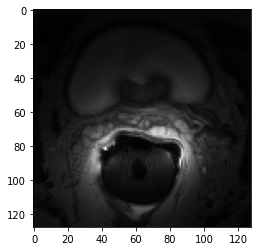

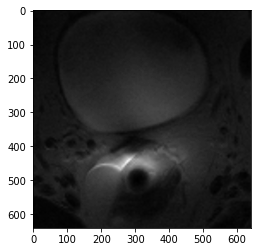

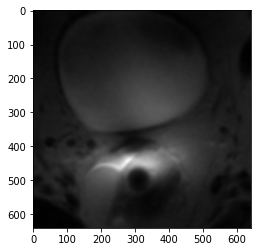

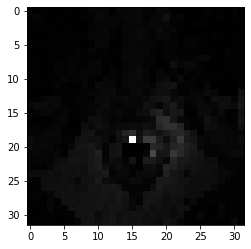

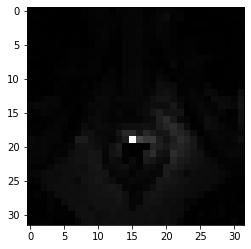

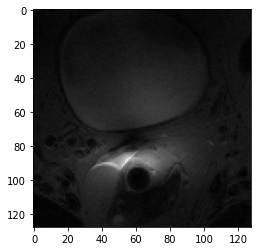

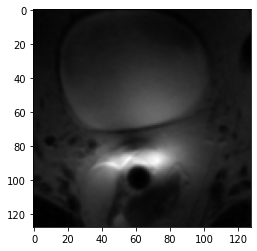

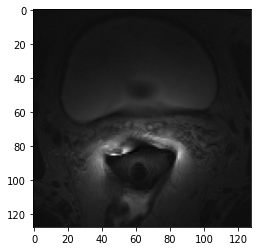

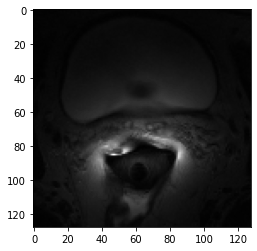

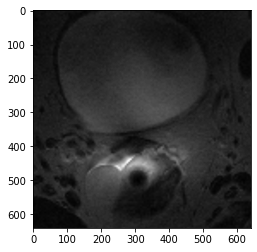

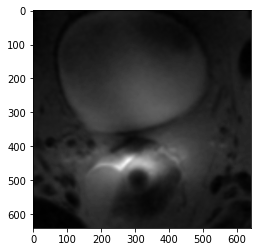

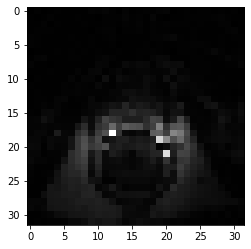

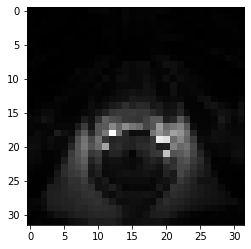

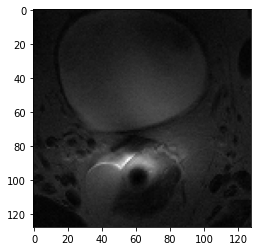

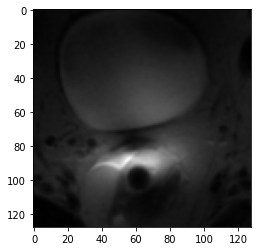

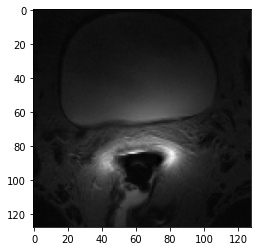

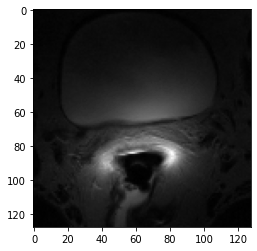

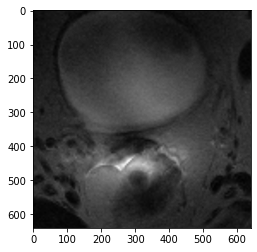

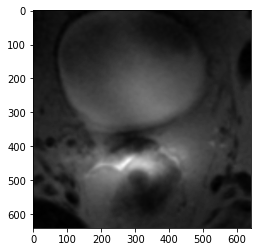

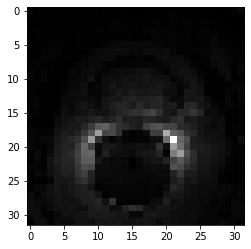

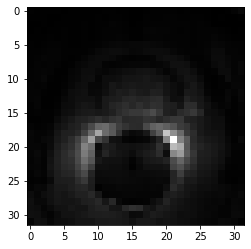

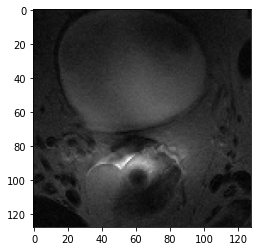

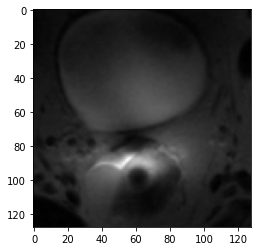

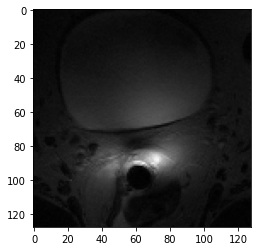

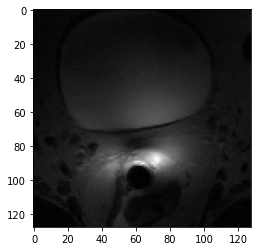

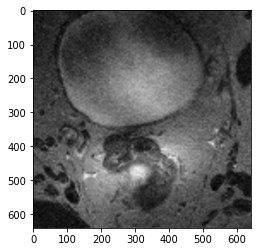

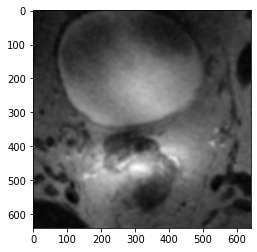

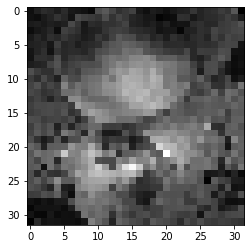

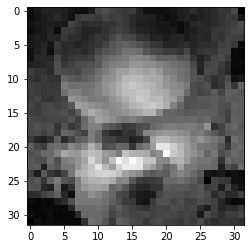

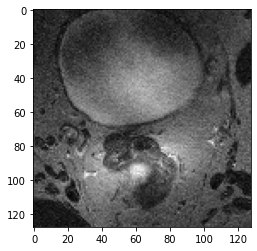

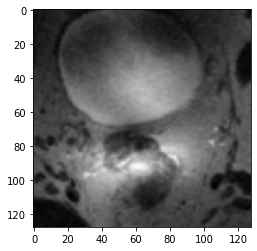

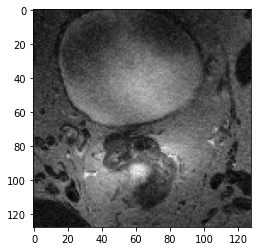

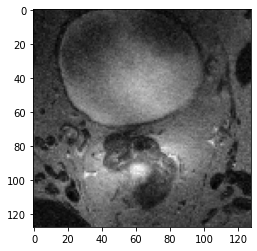

In [ ]:

######
# plot
######
for slice in [-10,-8,-6,-4,-1]:
    
    # visualize and save as png for results in experiment 1
    plt.subplot(111), plt.imshow(upsample[:,:, slice], cmap='gray')
    plt.savefig('exp1_scenario1_z{}_without_filter'.format(slice), transparent=True) #
    plt.show()

    plt.subplot(111), plt.imshow(upsample_filter[:,:,slice], cmap='gray')
    plt.savefig('exp1_scenario1_z{}_with_filter'.format(slice), transparent=True) #
    plt.show()
    
    try:
        plt.subplot(111), plt.imshow(downsample[:,:, slice], cmap='gray')
        plt.savefig('exp1_scenario2_z{}_without_filter'.format(slice), transparent=True) #
        plt.show()
    
        plt.subplot(111), plt.imshow(downsample_filter[:,:,slice], cmap='gray')
        plt.savefig('exp1_scenario2_z{}_with_filter'.format(slice), transparent=True) #
        plt.show()
    except: pass

    plt.subplot(111), plt.imshow(isosample[:,:,slice], cmap='gray')
    plt.savefig('exp1_scenario3_z{}_without_filter'.format(slice), transparent=True) #
    plt.show()

    plt.subplot(111), plt.imshow(isosample_filter[:,:,slice], cmap='gray')
    plt.savefig('exp1_scenario3_z{}_with_filter.png'.format(slice), transparent=True) #
    plt.show()


    # visualize and save as png for results in experiment 2
    plt.subplot(111), plt.imshow(exp2downsample[:,:,slice], cmap='gray')
    plt.savefig('exp2_z{}_without_filter'.format(slice), transparent=True) #'exp2_scenario1_z5_with_filter'
    plt.show()

    plt.subplot(111), plt.imshow(exp2downsample_filter[:,:,slice], cmap='gray')
    plt.savefig('exp2_z{}_with_filter'.format(slice), transparent=True) #'exp2_scenario1_z5_with_filter'
    plt.show()


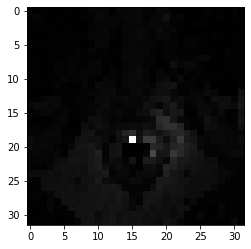

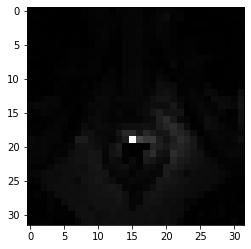

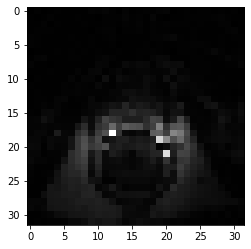

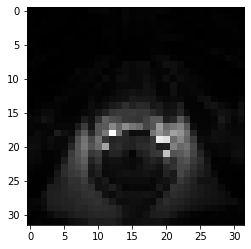

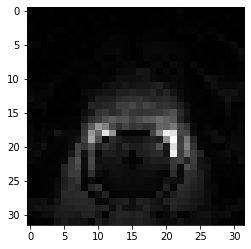

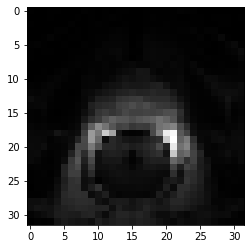

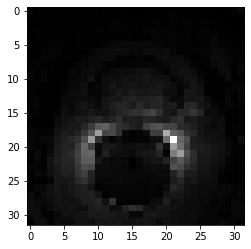

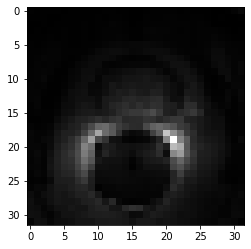

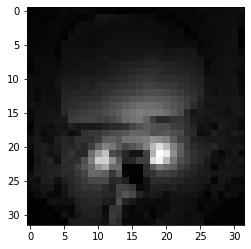

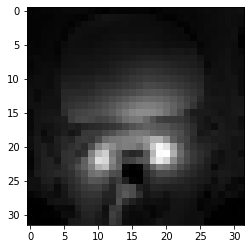

In [ ]:
for slice in [0,2,3,4,6]:
    plt.subplot(111), plt.imshow(downsample[:,:, slice], cmap='gray')
    plt.savefig('exp1_scenario2_z{}_without_filter'.format(slice), transparent=True) #
    plt.show()

    plt.subplot(111), plt.imshow(downsample_filter[:,:,slice], cmap='gray')
    plt.savefig('exp1_scenario2_z{}_with_filter'.format(slice), transparent=True) #
    plt.show()

[ 75 640 640]


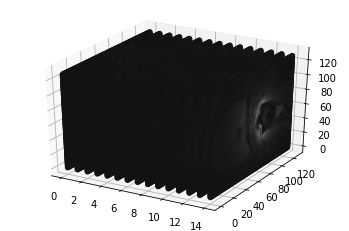

In [ ]:
import numpy as np
from scipy.interpolate import interpn
import matplotlib.pyplot as plt

def scatter(ijk, values,alpha):
    fig, ax = plt.subplots(subplot_kw =dict(projection="3d"))
    ax.scatter(ijk[0], ijk[1], ijk[2], c=values, alpha=alpha), ax.set_xlabel('x (mm)'), ax.set_ylabel('y (mm)'),ax.set_zlabel('z (mm)')
    # ax.scatter(ijk[0][0,0,0], ijk[1][0,0,0], ijk[2][0,0,0], c=ijk[2][0,0,0], edgecolor = "black")
    # ax.scatter(ijk[0][0,0,1], ijk[1][0,0,1], ijk[2][0,0,1], c=ijk[2][0,0,1], edgecolor = "black")
    # ax.scatter(i[1], j[1], k[1], c=k[1], edgecolor = "black")    
    plt.show()


values = np.load('/content/drive/MyDrive/ucl/image_train00.npy')[10:25,:,:] #(32, 128, 128)
dimen = values.shape
# z = np.linspace(0, 64, 32) in image size mm
# x = np.linspace(0, 64, 128)
# y = np.linspace(0, 64, 128)
z = np.linspace(0, dimen[0]-1, dimen[0])# in voxel dimension
x = np.linspace(0, dimen[1]-1, dimen[1])
y = np.linspace(0, dimen[2]-1, dimen[2])
zxy = np.indices(dimen) # for plot
# zxy_ = np.meshgrid(z,x,y)

resample_ratio = (0.35,1.5,1.5) #(12,3,3)
resample_ratio = (5,5,5) #(12,3,3)
new_dimen = (dimen*np.array(resample_ratio)).astype(int)
print(new_dimen)
new_z = np.linspace(0, dimen[0]-1, new_dimen[0])
new_x = np.linspace(0, dimen[1]-1, new_dimen[1])
new_y = np.linspace(0, dimen[2]-1, new_dimen[2])
new_z, new_x, new_y = np.meshgrid(new_z, new_x, new_y)
interped = interpn((z,x,y), values, (new_z,new_x,new_y))

fig, ax = plt.subplots(subplot_kw =dict(projection="3d"))
ax.scatter(zxy[0], zxy[1], zxy[2], c=values, alpha=0.8, cmap='gray')#, edgecolor = "black")
plt.show(fig)

fig, ax = plt.subplots(subplot_kw =dict(projection="3d"))
ax.scatter(new_z, new_x, new_y, c=interped, alpha=0.2, cmap='gray'), ax.set_xlabel('x (mm)'), ax.set_ylabel('y (mm)'),ax.set_zlabel('z (mm)')
plt.show(fig)

plt.subplot(111), plt.imshow(interped.transpose(0,2,1)[:,:,-1], cmap='gray')


In [ ]:
# np.meshgrid() np.linsapce() np.indices() np.arange()

gx, gy, gz = np.meshgrid(3,4,5)# (1, 1, 1) 
# [[[3]]]
mx, my, mz = np.meshgrid(np.arange(3),np.arange(4),np.arange(5))# (4, 3, 5)
# [[[0 0 0 0 0]
#   [1 1 1 1 1]
#   [2 2 2 2 2]]

#  [[0 0 0 0 0]
#   [1 1 1 1 1]
#   [2 2 2 2 2]]

#  [[0 0 0 0 0]
#   [1 1 1 1 1]
#   [2 2 2 2 2]]

#  [[0 0 0 0 0]
#   [1 1 1 1 1]
#   [2 2 2 2 2]]]
gxyz = np.meshgrid(np.arange(3),np.arange(4),np.arange(5)) # (3 items list) [ndarray with shape (4,3,5),...

ix, iy,iz = np.indices((3,4,5))#(3, 4, 5)
# [[[0 0 0 0 0]
#   [0 0 0 0 0]
#   [0 0 0 0 0]
#   [0 0 0 0 0]]

#  [[1 1 1 1 1]
#   [1 1 1 1 1]
#   [1 1 1 1 1]
#   [1 1 1 1 1]]

#  [[2 2 2 2 2]
#   [2 2 2 2 2]
#   [2 2 2 2 2]
#   [2 2 2 2 2]]]
ixyz = np.indices((3,4,5))# (3, 3, 4, 5)
# [[[[0 0 0 0 0]
#    [0 0 0 0 0]
#    [0 0 0 0 0]
#    [0 0 0 0 0]]

#   [[1 1 1 1 1]
#    [1 1 1 1 1]
#    [1 1 1 1 1]
#    [1 1 1 1 1]]

#   [[2 2 2 2 2]
#    [2 2 2 2 2]
#    [2 2 2 2 2]
#    [2 2 2 2 2]]]


#  [[[0 0 0 0 0]
#    [1 1 1 1 1]
#    [2 2 2 2 2]
#    [3 3 3 3 3]]

#   [[0 0 0 0 0]
#    [1 1 1 1 1]
#    [2 2 2 2 2]
#    [3 3 3 3 3]]

#   [[0 0 0 0 0]
#    [1 1 1 1 1]
#    [2 2 2 2 2]
#    [3 3 3 3 3]]]


#  [[[0 1 2 3 4]
#    [0 1 2 3 4]
#    [0 1 2 3 4]
#    [0 1 2 3 4]]

#   [[0 1 2 3 4]
#    [0 1 2 3 4]
#    [0 1 2 3 4]
#    [0 1 2 3 4]]

#   [[0 1 2 3 4]
#    [0 1 2 3 4]
#    [0 1 2 3 4]
#    [0 1 2 3 4]]]]
x = np.linspace(0, 4, 4)#  (4,) print(np.linspace(0, 3, 4))same with arange(4)
# [0.         1.33333333 2.66666667 4.        ]
a = np.arange(4)#  (4,) 
# [0 1 2 3]


[[ 0  1  2  3  4  5  6  7  8  9]
 [ 1  2  3  4  5  6  7  8  9 10]
 [ 2  3  4  5  6  7  8  9 10 11]
 [ 3  4  5  6  7  8  9 10 11 12]
 [ 4  5  6  7  8  9 10 11 12 13]
 [ 5  6  7  8  9 10 11 12 13 14]
 [ 6  7  8  9 10 11 12 13 14 15]
 [ 7  8  9 10 11 12 13 14 15 16]
 [ 8  9 10 11 12 13 14 15 16 17]
 [ 9 10 11 12 13 14 15 16 17 18]]


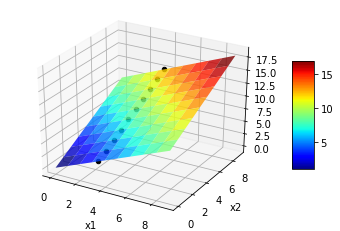

In [ ]:
# https://stackoverflow.com/questions/27286537/numpy-efficient-way-to-generate-combinations-from-given-ranges/27286794#27286794
# https://stackoverflow.com/questions/39332053/using-scipy-interpolate-interpn-to-interpolate-a-n-dimensional-array
# understand scipy interpn

from scipy.interpolate import interpn
import numpy as np
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

# Set up grid and array of values
x1 = np.arange(10)
x2 = np.arange(10)
arr = x1 + x2[:, np.newaxis] # ndarray with shape (10, 10)
print(arr)

# Set up grid for plotting
X, Y = np.meshgrid(x1, x2)

# Plot the values as a surface plot to depict
fig, ax = plt.subplots(subplot_kw =dict(projection="3d"))  
surf = ax.plot_surface(X, Y, arr, rstride=1, cstride=1, cmap='jet', linewidth=0, alpha=0.8)
fig.colorbar(surf, shrink=0.5, aspect=5)




interp_x = 3.5           # Only one value on the x1-axis
interp_y = np.arange(10) # A range of values on the x2-axis

# set up the interpolation points as a 10x2 array!
interp_mesh = np.array(np.meshgrid(interp_x, interp_y))
interp_points = np.rollaxis(interp_mesh, 0, 3).reshape((10, 2))

# Perform the interpolation
interp_arr = interpn((x1, x2), arr, interp_points)

# Plot the result
ax.scatter(interp_x * np.ones(interp_y.shape), interp_y, interp_arr, s=20, c='k', depthshade=False)
plt.xlabel('x1'), plt.ylabel('x2')
plt.show()

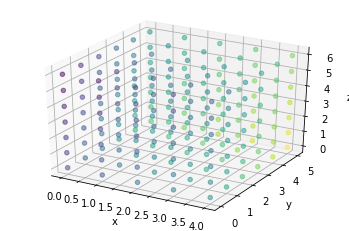

[12.63]
[ 0.          1.88888889  3.77777778  5.66666667  7.55555556  9.44444444
 11.33333333 13.22222222 15.11111111 17.        ]


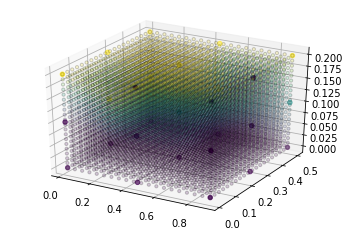

In [ ]:
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import numpy as np
from scipy.interpolate import interpn

# https://stackoverflow.com/questions/74150690/how-to-use-scipy-interpolate-interpn-function-with-xarray-3d-to-fill-nan-gaps

def value_func_3d(x, y, z):
    return 2 * x + 3 * y - z

x = np.linspace(0, 4, 5)# (5,)
y = np.linspace(0, 5, 6)
z = np.linspace(0, 6, 7)
points = (x, y, z)# 3-item tuple (ndarray(5,), (6,) (7,))
# grid = np.meshgrid(x, y, z, indexing='ij')#3-item list [ndarray(5, 6, 7), (5, 6...] xxx, yyy, zzz
values = value_func_3d(*np.meshgrid(*points, indexing='ij'))# ndarray with shape (5, 6, 7)
scatter(np.indices((5,6,7)), values, 0.5)

point = np.array([2.21, 3.12, 1.15])
interped = interpn(points, values, point)
print(interped)

pad = 0
xg = np.linspace(min(x)-pad, max(x)+pad,10)# (10,)
yg = np.linspace(min(y)-pad, max(y)+pad,10)
zg = np.linspace(min(z)-pad, max(z)+pad,10)
pointsg = (xg, yg, zg)
interped = interpn(points, values, pointsg)# (10,)=(ndarray(5,), (6,) (7,))  ndarray with shape (5, 6, 7)   ((10,), (10,), (10,))
print(interped)

########################
# griddata vs interpn
# griddata(points, values, xi[, method, ...]) Interpolate unstructured D-D data.
# interpn(points, values, xi[, method, ...]) Multidimensional interpolation on regular or rectilinear grids.
# fill gaps in a regular grid vs interpolate a full regular grid (with no gaps) to different coordinates
########################


x = [0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.46,0.46,0.46,0.46,0.46,0.46,0.46,0.46,0.46,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,]
y = [0.01,0.01,0.01,0.255,0.255,0.255,0.5,0.5,0.5,0.01,0.01,0.01,0.255,0.255,0.255,0.5,0.5,0.5,0.01,0.01,0.01,0.255,0.255,0.255,0.5,0.5,0.5,]
z = [0.,0.1,0.2,0.,0.1,0.2,0.,0.1,0.2,0.,0.1,0.2,0.,0.1,0.2,0.,0.1,0.2,0.,0.1,0.2,0.,0.1,0.2,0.,0.1,0.2]
values = [0.,0.,1.,0.,1.,1.,0.,1.,1.,0.,0.,0.,0.,0.5,1.,0.,1.,1.,0.,0.,0.,0.,0.,0.,0.,0.5,1.,]
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
c = ax.scatter(x, y, z, c=values)# ax.scatter(0.51, 0.32, 0.12, c=[p], s=50)#, cmap = plt.cm.bwr
points = np.array([x, y, z])

pad = 0
xg = np.linspace(min(x)-pad, max(x)+pad,20)
yg = np.linspace(min(y)-pad, max(y)+pad,20)
zg = np.linspace(min(z)-pad, max(z)+pad,20)
X, Y, Z = np.meshgrid(xg, yg, zg)
vinterp = griddata(points.T, values, (X, Y, Z))#(20, 20, 20)
ci = ax.scatter(X.ravel(), Y.ravel(), Z.ravel(), c=vinterp.ravel(), s=10,  edgecolor = "black", alpha = 0.2)
plt.show()

In [ ]:
#                 you want to read
#                 in this direction
#                  (0, 0)   (0, 1)
#                    |        |
#                    |        |
#                    v        v

#           /        0--------0            +----> axis0
#  x-values |       /|       /|           /|
#           |      / |      / |    axis1 / |
#           \     1--------1  |         L  |
#                 |  |     |  |            v
#           /     |  0-----|--1           axis2
#  y-values |     | /      | /
#           |     |/       |/
#           \     0--------1

#                 |        |
#                 |        |
#                 v        v
#               (1, 0)   (1, 1)
              
a = np.mgrid[0:4, 0:4, 0:11]     # All points in a 3D grid within the given ranges
a = np.rollaxis(a, 0, 4)         # Make the 0th axis into the last axis
a = a.reshape((4 * 4 * 11, 3))   # Now you can safely reshape while preserving order
# [ [a[0][0, 0], a[1][0, 0]],
#   [a[0][0, 1], a[1][0, 1]],
#   [a[0][1, 0], a[1][1, 0]],
#   [a[0][1, 1], a[1][1, 1]] ]

a = np.mgrid[0:2, 0:2]
# >>> a
# array([[[0, 0],
#         [1, 1]],

#        [[0, 1],
#         [0, 1]]])
a = np.rollaxis(a, 0, 3)
# >>> a
# array([[[0, 0],
#         [0, 1]],

#        [[1, 0],
#         [1, 1]]])
a = a.reshape((4, 2))
# >>> a
# array([[0, 0],
#        [0, 1],
#        [1, 0],
#        [1, 1]]) 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interpn
from scipy.interpolate import interp1d

fs = [
    lambda x : (x - 3) * (x + 3) * x, # cubic
    lambda x : np.exp(-x**2 / 2),     # gaussian
    lambda x : np.sin(3*x) / (3*x),       # sinc function
    lambda x : 1 / (np.exp(-2*x) + 1)   # logistic
]
x = np.linspace(-4,4,100)
x6 = np.linspace(-4,4,6)
fig, ax = plt.subplots(2, 2, figsize=(4,4))
ax = ax.flatten()

for i, f in enumerate(fs):
    ax[i].plot(x, f(x))
    ax[i].scatter(x6, f(x6))
    # ax[i].plot(x6, f(x6), 'b')
    interp = interp1d(x6, f(x6))
    ax[i].plot(x, interp(x), '--') 
plt.show(fig)

kinds = ('linear', 'nearest', 'quadratic', 'cubic')
f = fs[2]

x = np.linspace(-4,4,500)
xk = np.linspace(-4,4,10)

fig, ax = plt.subplots(2, 2, figsize=(4,4))
ax = ax.flatten()

for i, kind in enumerate(kinds):
    y = f(x)
    ax[i].plot(x, y)
    
    yk = f(xk)
    ax[i].scatter(xk, yk)
    
    interp = interp1d(xk, yk, kind=kind)
    ax[i].plot(x, interp(x), '--')
    ax[i].set_title(kind)
    
plt.show(fig)

In [ ]:

shape = np.array(image.shape)
# calculate the center of the image
center = (shape - 1) / 2
# create a grid with the voxel dimension
x, y, z = np.meshgrid(np.arange(-center[0], center[0]+1, voxel_dimension[0]),
                      np.arange(-center[1], center[1]+1, voxel_dimension[1]),
                      np.arange(-center[2], center[2]+1, voxel_dimension[2]))


In [ ]:
from scipy.ndimage import zoom
new_array = zoom(array, (0.5, 0.5, 2))

# https://scikit-image.org/docs/dev/auto_examples/transform/plot_rescale.html
#gaussian

#https://stackoverflow.com/questions/39332053/using-scipy-interpolate-interpn-to-interpolate-a-n-dimensional-array
#interpoln


#resampled the volume to unit isotropic voxel spacing (i.e. 1mm x 1mm x 1mm)

In [ ]:
#https://stackoverflow.com/questions/43922198/how-to-rotate-a-3d-image-by-a-random-angle-in-python

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# label_array = label_array*255
slice_ = [23,32,45]
img_tran = Image.fromarray(label_array[slice_[0],:,:], 'P')#"L":"Luminance" single-channel/greyscale. 
img_sagi = Image.fromarray(label_array[:,:,slice_[2]], 'P')# "P": palette with up to 256 different colours
img_coro = Image.fromarray(label_array[:,slice_[1],:], 'P')
save_img = img_tran.convert('L').save("transverse_{:03d}_{:04d}_{:04d}.jpeg".format(slice_[0],slice_[1],slice_[2]))  
plt.subplot(221), plt.imshow(img_tran), plt.xlabel('R-L'), plt.ylabel('A-P')
plt.subplot(222), plt.imshow(img_sagi), plt.xlabel('A-P'), plt.ylabel('S-I')
plt.subplot(224), plt.imshow(img_coro), plt.xlabel('R-L'), plt.ylabel('S-I')

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

label_arr = np.load('/content/image_train00.npy') #(32, 128, 128)

s_i, a_p, l_r = label_arr.shape

label_trans = Image.fromarray(np.reshape(label_arr, (-1, a_p * l_r)))
label_saggi = Image.fromarray(np.reshape(label_arr.transpose(2,0,1), (-1,a_p * s_i)))
label_coron = Image.fromarray(np.reshape(label_arr.transpose(1,0,2), (-1,l_r * s_i)))


norm= plt.Normalize(label_arr.min(), label_arr.max())
plt.subplot(221), plt.imshow(label_trans, norm=norm, extent=[0, l_r*0.5, 0, a_p*0.5]), plt.title('transverse')
plt.subplot(222), plt.imshow(label_saggi, extent=[0, a_p*0.5, 0, s_i*2]), plt.title('saggital')
plt.subplot(224), plt.imshow(label_coron, extent=[0, l_r*0.5, 0, s_i*2]), plt.title('coronal')


(<matplotlib.axes._subplots.AxesSubplot at 0x7fbde3135910>,
 <matplotlib.image.AxesImage at 0x7fbde2823520>)

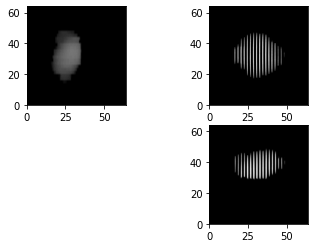

In [ ]:
import matplotlib.pyplot as plt


label_arr = np.load('/content/label_train00.npy') #(32, 128, 128)
s_i, a_p, l_r = label_arr.shape

label_trans = np.reshape(label_arr, (-1, a_p * l_r))
label_saggi = np.reshape(label_arr.transpose(2,0,1), (-1, a_p * s_i))
label_coron = np.reshape(label_arr.transpose(1,0,2), (-1, l_r * s_i))
# label_saggi = np.reshape(label_arr, (a_p * s_i, -1))
# label_coron = np.reshape(label_arr.transpose(0,2,1), (l_r * s_i, -1))

plt.subplot(221), plt.imshow(label_trans, cmap='gray', extent=[0, l_r*0.5, 0, a_p*0.5])
plt.subplot(222), plt.imshow(label_saggi, cmap='gray', extent=[0, a_p*0.5, 0, s_i*2], interpolation='spline36')
plt.subplot(224), plt.imshow(label_coron, cmap='gray', extent=[0, l_r*0.5, 0, s_i*2], interpolation='hamming')
